# Efficiency, Explainability and Environmental Sustainability in Wastewater Treatment: A Machine Learning-Based Approach to Cost Management and Effluent Quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns

In [2]:
# read the hourly data
df_hourly = pd.read_csv('data/df_hourly.csv')

In [3]:
df_hourly.head()

,t,Qi,T,CODi,NH4i,TNi,TSSi,TPi,Qintr,Qr,...,TNo,TSSo,TPo,EQI,SC,AE,PE,ME,OCI,EQI_original
0,0.015625,14406.28225,19.737112,614.746915,19.151799,44.068632,355.109175,8.031241,48134.831,25411.192,...,8.558629,12.121001,1.113214,6677.886750,12132.98000,3933.728500,864.843970,5481.689250,18422.37825,4605.147088
1,0.057292,12837.01100,19.618762,584.179823,16.709277,40.653262,341.804230,8.819089,48134.831,25411.192,...,8.591077,11.486679,1.034620,6464.858700,11993.34150,3545.029650,864.827172,5485.683575,17890.02975,3969.606172
2,0.098958,11749.33225,19.491398,528.349775,14.732324,36.651249,311.960990,8.262622,48134.831,25411.192,...,8.602270,11.144210,0.989105,6344.323675,11878.62725,3246.704825,864.815327,5489.732950,17472.92975,3564.484951
3,0.140625,10914.30350,19.363810,482.648807,14.911990,35.107291,286.976783,7.929862,48134.831,25411.192,...,8.565928,10.953440,0.969153,6281.458800,11783.81600,3039.385450,864.807775,5492.915875,17167.60850,3277.822528
4,0.182292,10515.67700,19.244801,446.465233,14.049397,32.696661,263.812485,7.311440,48134.831,25411.192,...,8.474410,10.839923,0.971374,6260.303300,11648.92400,2884.520650,864.797603,5493.965150,16876.79250,3145.719067


In [4]:
df_hourly.drop(columns=['t', 'EQI'], inplace=True)

In [5]:
df_delay_XX_hours = df_hourly
df_delay_XX_hours.rename(columns={'EQI_original': 'EQI'}, inplace=True)
df_delay_XX_hours

,Qi,T,CODi,NH4i,TNi,TSSi,TPi,Qintr,Qr,Qw,...,NH4o,TNo,TSSo,TPo,SC,AE,PE,ME,OCI,EQI
0,14406.28225,19.737112,614.746915,19.151799,44.068632,355.109175,8.031241,48134.831,25411.192,476.45151,...,0.133928,8.558629,12.121001,1.113214,12132.98000,3933.728500,864.843970,5481.689250,18422.37825,4605.147088
1,12837.01100,19.618762,584.179823,16.709277,40.653262,341.804230,8.819089,48134.831,25411.192,476.45151,...,0.132271,8.591077,11.486679,1.034620,11993.34150,3545.029650,864.827172,5485.683575,17890.02975,3969.606172
2,11749.33225,19.491398,528.349775,14.732324,36.651249,311.960990,8.262622,48134.831,25411.192,476.45151,...,0.129067,8.602270,11.144210,0.989105,11878.62725,3246.704825,864.815327,5489.732950,17472.92975,3564.484951
3,10914.30350,19.363810,482.648807,14.911990,35.107291,286.976783,7.929862,48134.831,25411.192,476.45151,...,0.124853,8.565928,10.953440,0.969153,11783.81600,3039.385450,864.807775,5492.915875,17167.60850,3277.822528
4,10515.67700,19.244801,446.465233,14.049397,32.696661,263.812485,7.311440,48134.831,25411.192,476.45151,...,0.120406,8.474410,10.839923,0.971374,11648.92400,2884.520650,864.797603,5493.965150,16876.79250,3145.719067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,22280.07700,19.957798,716.726378,28.802786,57.082764,398.481652,13.291094,66247.012,28275.330,614.56807,...,0.135538,10.007595,13.543696,1.437180,13157.64025,4712.625150,1069.910475,5705.004650,20292.58775,8311.408718
8732,22516.32750,19.977234,680.968467,25.881294,53.193089,387.179222,12.271937,66247.012,28275.330,614.56807,...,0.133387,9.735007,14.021078,1.444248,13306.95500,5035.466825,1069.924875,5698.191475,20771.57200,8411.718742
8733,18464.83700,19.962686,718.497793,26.427896,55.284096,410.219975,12.952948,66247.012,28275.330,614.56807,...,0.139391,9.511714,13.255109,1.372332,13336.80125,4929.957425,1069.925675,5699.386225,20694.71450,6670.274914
8734,15457.20550,19.915253,722.257912,25.630474,54.933458,420.928455,12.654632,66247.012,28275.330,614.56807,...,0.146743,9.396183,12.209047,1.265232,13216.13400,4483.583075,1069.908850,5702.092900,20124.94950,5329.429387


In [6]:
list_hours_shifted = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15']
fname_prefix = 'data/df_delay_'
fname_postfix='_hours_result_sim2.pkl'

# read the hourly data

for ii in list_hours_shifted:
    file_name = [fname_prefix + ii + fname_postfix]
    print(file_name)
    
    file_name = df_delay_XX_hours.copy(deep=True)
    file_name = df_delay_XX_hours.copy(deep=True)
    list_names = list(df_delay_XX_hours.columns)
    
    
    list_names = list(df_delay_XX_hours.columns)
    for kk in range(1,int(ii)+1):

        shift_no = str(kk)
        df_shift = df_delay_XX_hours.shift(kk)

        # Rename shifted columns
        list_names_new = list(df_delay_XX_hours.columns)
        #print(ii, len(list_names_new))
        iter = len(list_names_new)
        for jj in range(0,iter):
            list_names_new[jj] = list_names[jj]+shift_no
                #print(list_names_new[jj])
            #print(ii, len(list_names))
        df_shift.columns = list_names_new

            # concatenate the shifted inputs
        file_name = pd.concat([file_name, df_shift], axis=1)
        
        
    file_name.dropna(inplace=True)
    file_name.to_pickle(fname_prefix + ii + fname_postfix)

['data/df_delay_1_hours_result_sim2.pkl']
['data/df_delay_2_hours_result_sim2.pkl']
['data/df_delay_3_hours_result_sim2.pkl']
['data/df_delay_4_hours_result_sim2.pkl']
['data/df_delay_5_hours_result_sim2.pkl']
['data/df_delay_6_hours_result_sim2.pkl']
['data/df_delay_7_hours_result_sim2.pkl']
['data/df_delay_8_hours_result_sim2.pkl']
['data/df_delay_9_hours_result_sim2.pkl']
['data/df_delay_10_hours_result_sim2.pkl']
['data/df_delay_11_hours_result_sim2.pkl']
['data/df_delay_12_hours_result_sim2.pkl']
['data/df_delay_13_hours_result_sim2.pkl']
['data/df_delay_14_hours_result_sim2.pkl']
['data/df_delay_15_hours_result_sim2.pkl']


In [7]:
# Bounds for hyperparameters
param_grid = {
    'max_depth': [2, 5, 9, 10, 12],
    'max_features': ["sqrt", 1, 2, 3],
    'min_samples_leaf': [0.2, 0.4],
    'min_samples_split': [0.2, 0.4],
    'n_estimators': [5, 10, 20, 30, 40, 50]
}

test_size = [0.1, 0.2, 0.3]

In [8]:
def evaluate(model, X, y):
    
    pred = model.predict(X)
    mae = metrics.mean_absolute_error(y, pred)
    mse = metrics.mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    
    mape = np.mean(np.abs((y - pred) / np.abs(y)))
    
    errors = abs(pred - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    
    
    return accuracy, mae, mse, rmse, mape

## Grid search with Random Forest Regressor

In [9]:
def plot_results(model, param='n_estimators'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    mean_train_scores = model.cv_results_['mean_train_score']
    mean_test_scores = model.cv_results_['mean_test_score']
    #train_time = model.cv_results_['mean_fit_time']
    params = list(model.cv_results_[param_name])
    train_score_dict = {}
    test_score_dict = {}
    for train_score, test_score, n_est in zip(mean_train_scores, mean_test_scores, params):
        train_score_dict.setdefault(n_est, []).append(train_score)
        test_score_dict.setdefault(n_est, []).append(test_score)

    # Calculate mean and std dev of scores for each 'n_estimators'
    mean_train_scores = {n_est: np.mean(scores) for n_est, scores in train_score_dict.items()}
    mean_test_scores = {n_est: np.mean(scores) for n_est, scores in test_score_dict.items()}

    # Sort the scores and standard deviations for plotting
    sorted_n_estimators = sorted(mean_train_scores)
    sorted_mean_train_scores = [mean_train_scores[n_est] for n_est in sorted_n_estimators]
    sorted_mean_test_scores = [mean_test_scores[n_est] for n_est in sorted_n_estimators]
    
    # Plotting the graph
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_n_estimators, sorted_mean_train_scores, 'bo-', label='train')
    plt.plot(sorted_n_estimators, sorted_mean_test_scores, 'go-', label='test')
    plt.xlabel(f'{param}')
    plt.ylabel('Mean Score')
    plt.title(f'Effect of {param} on Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()    

no delay


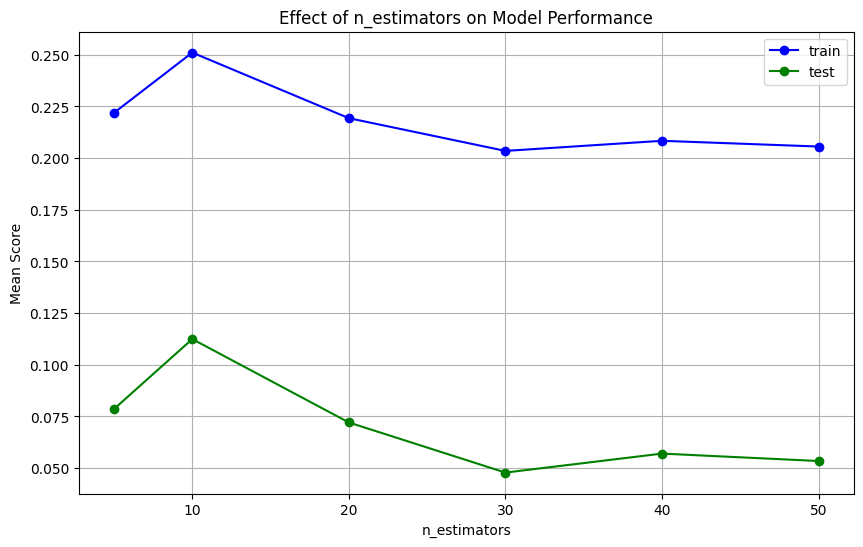

1


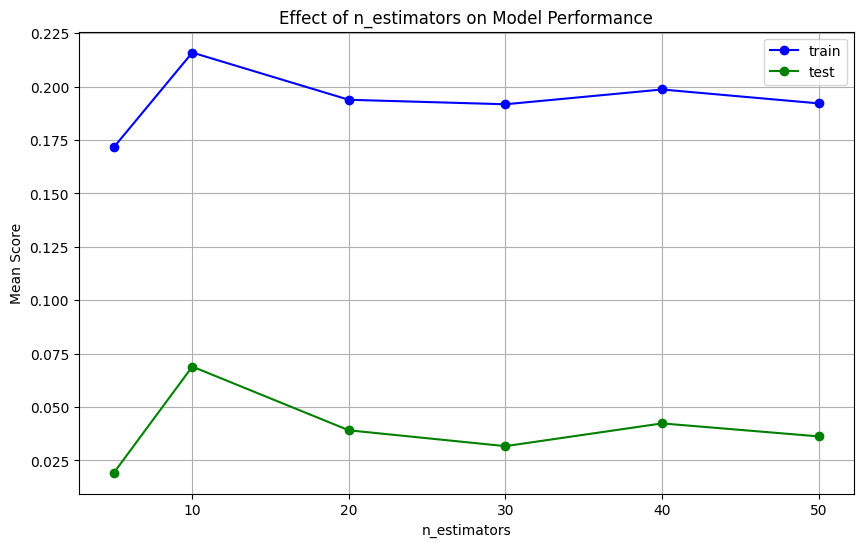

2


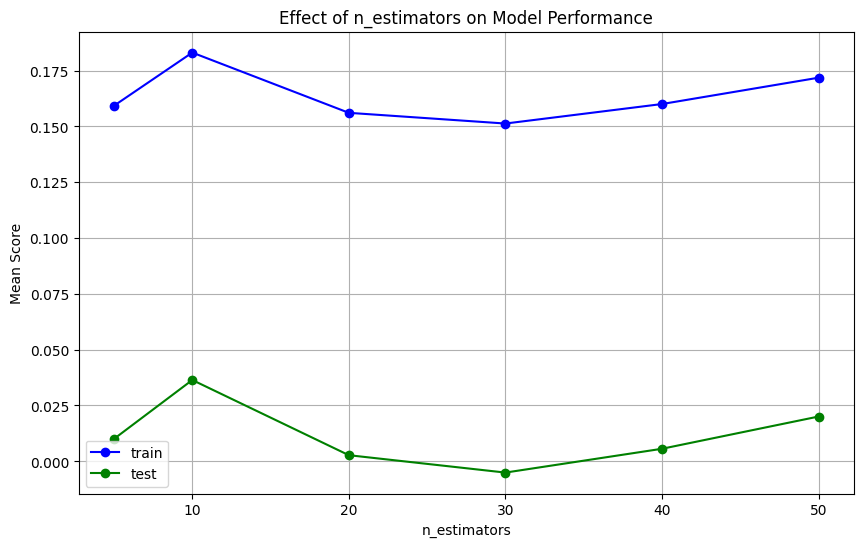

3


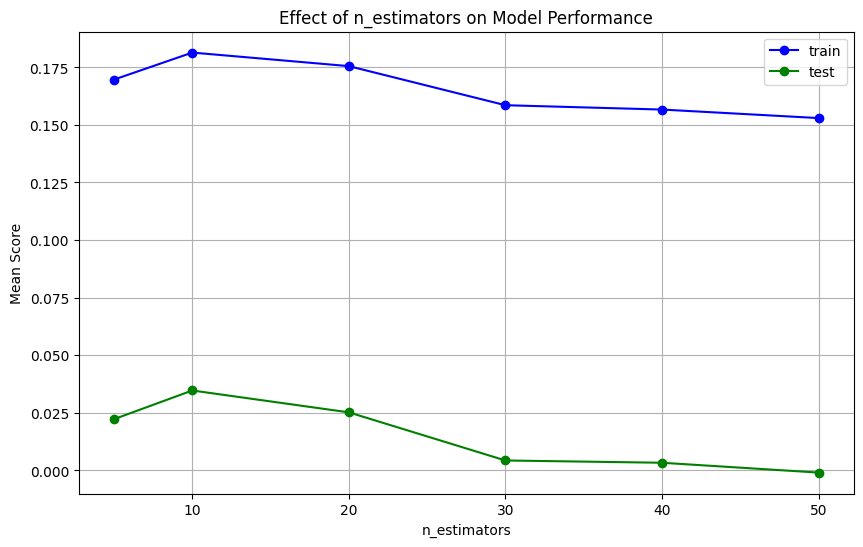

4


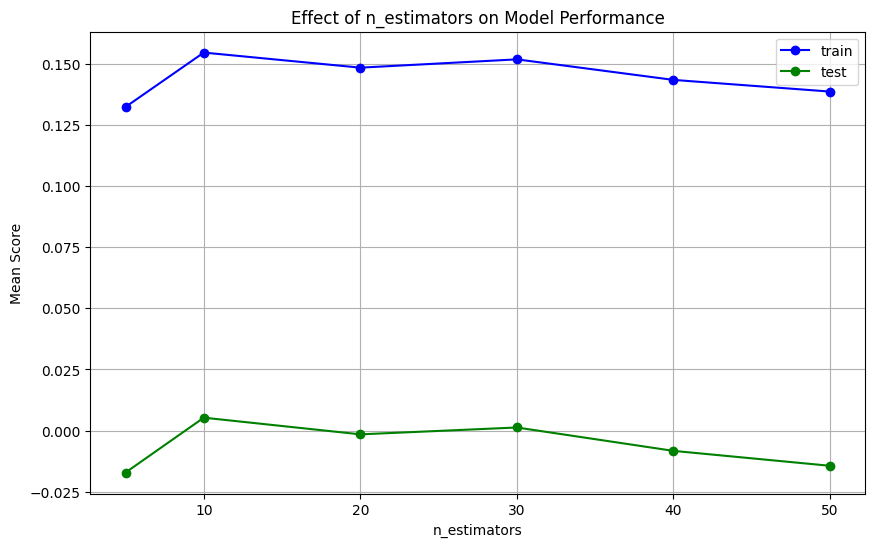

5


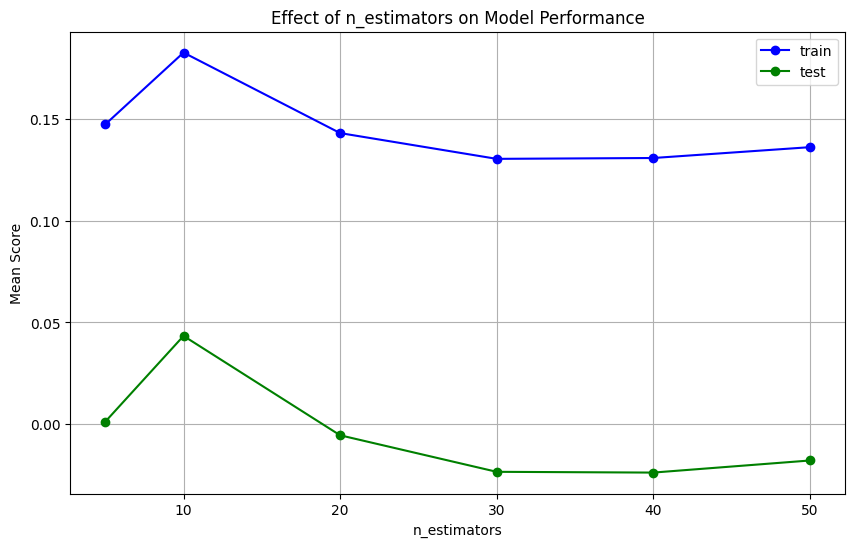

6


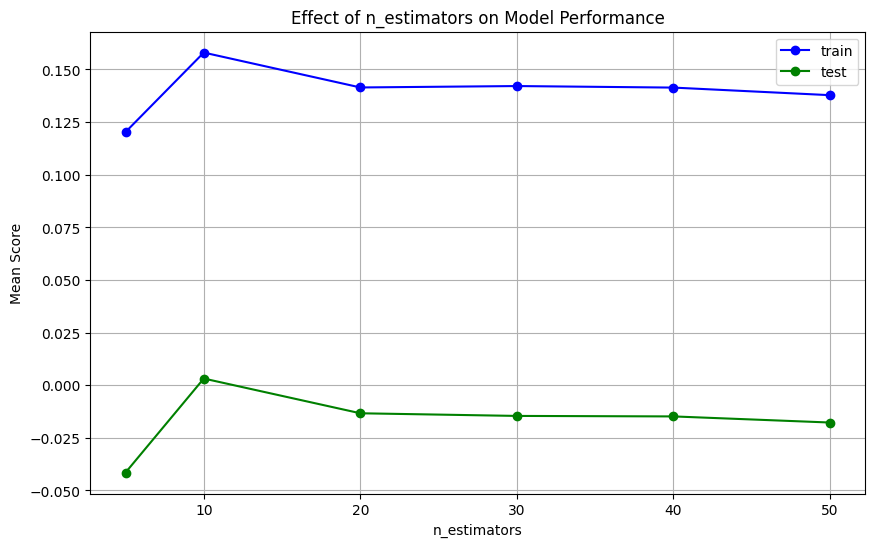

7


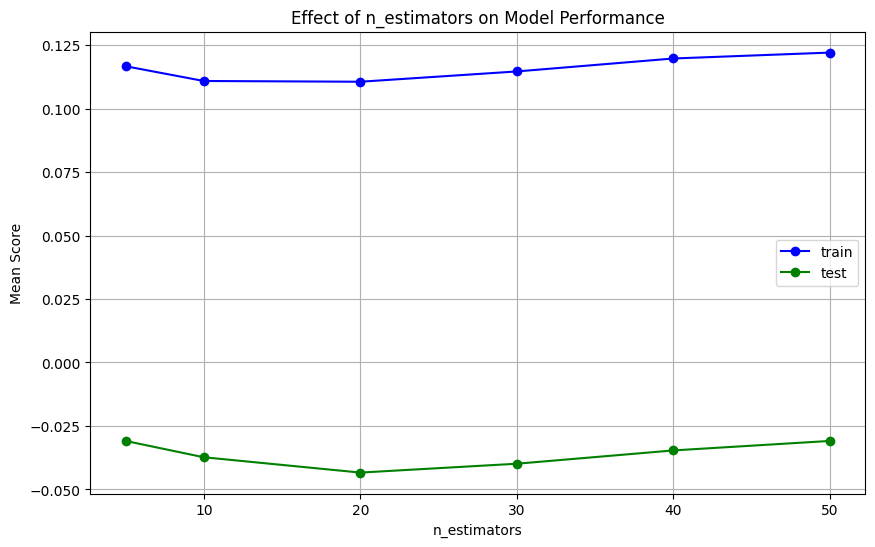

8


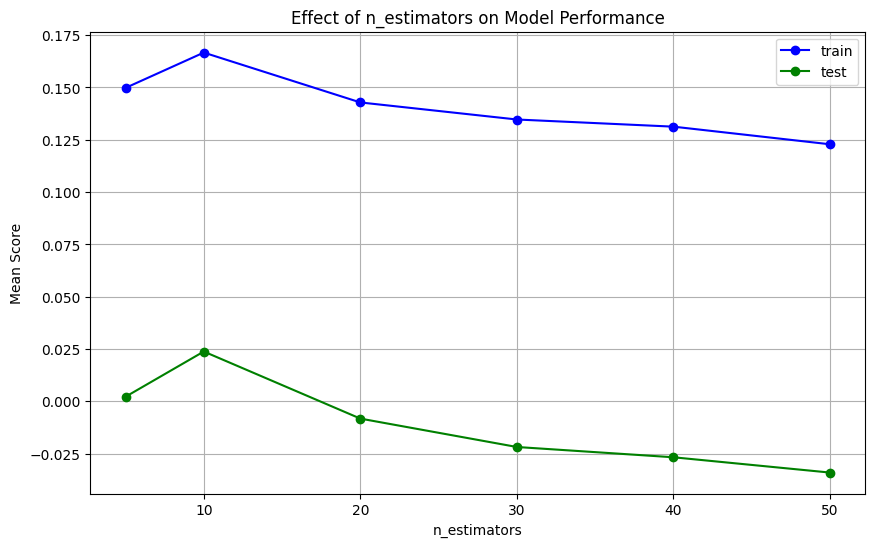

9


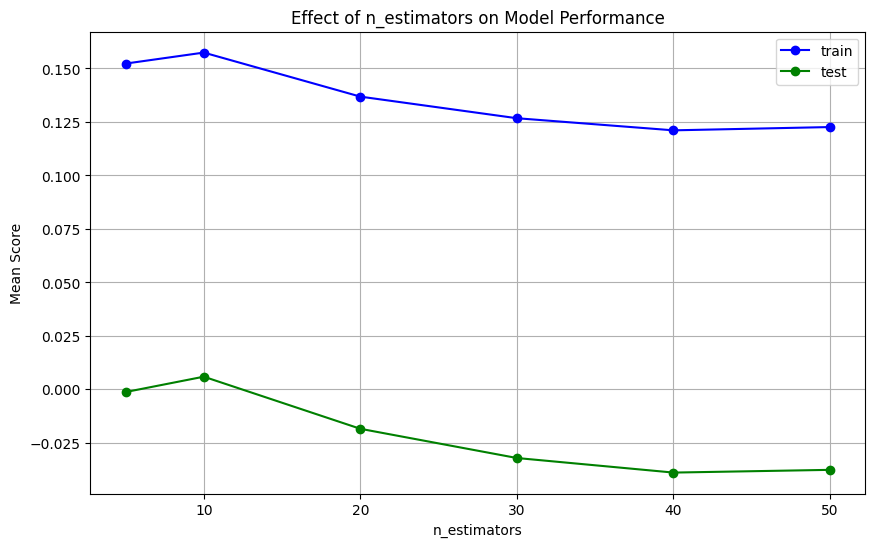

10


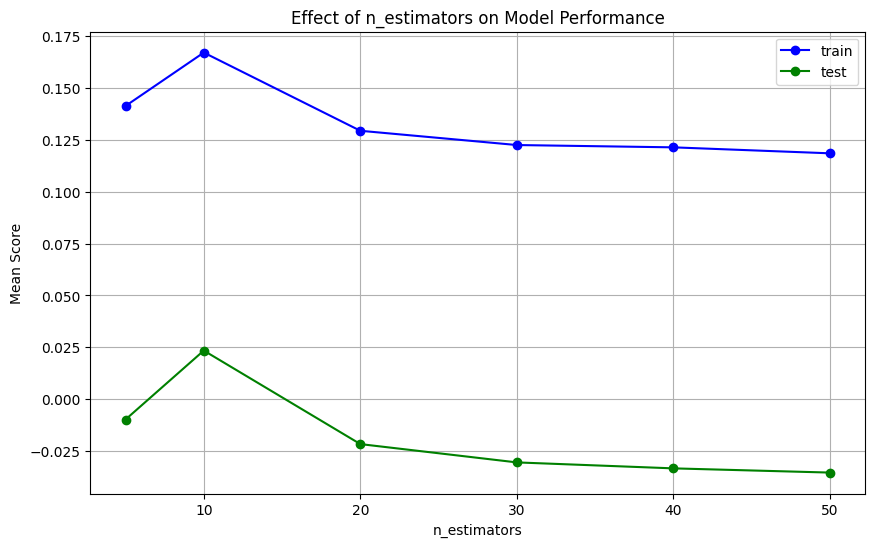

11


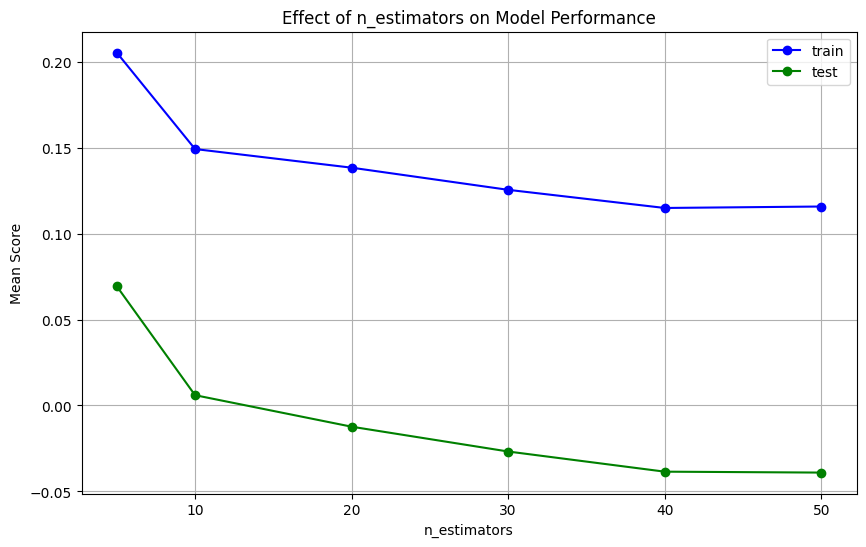

12


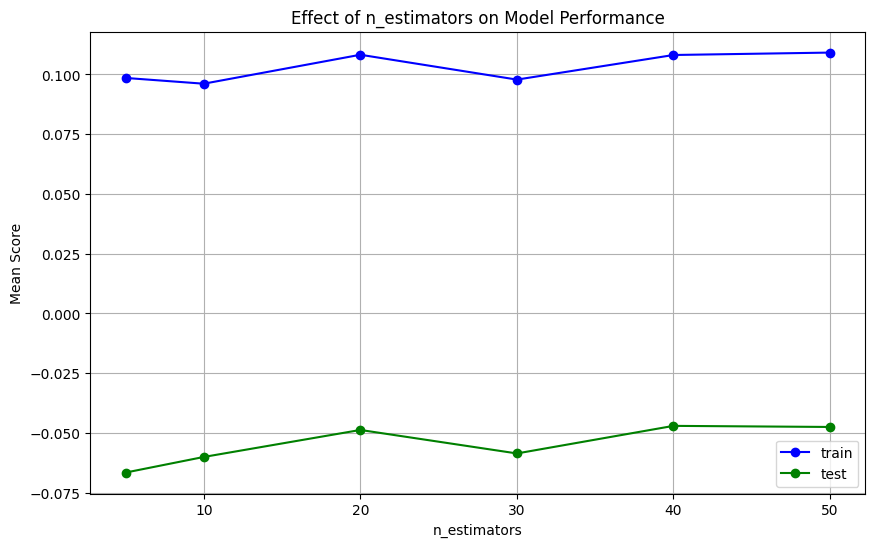

13


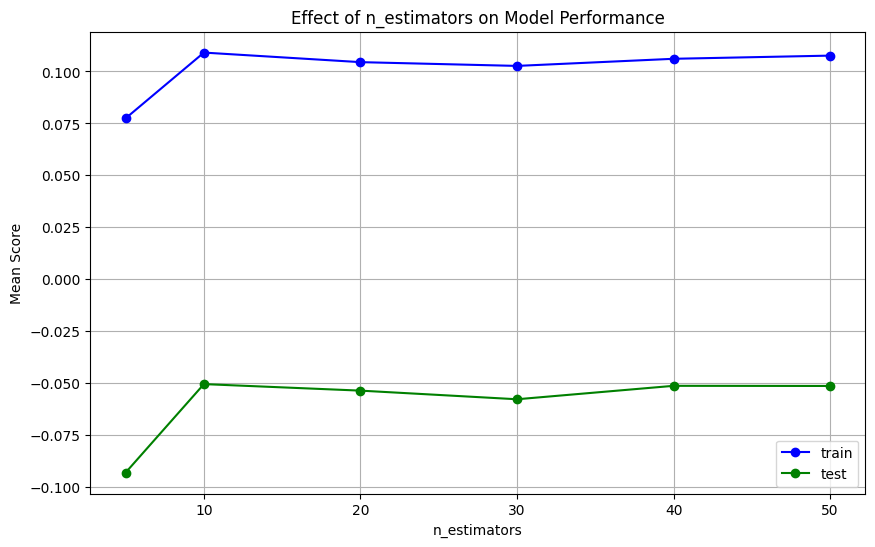

14


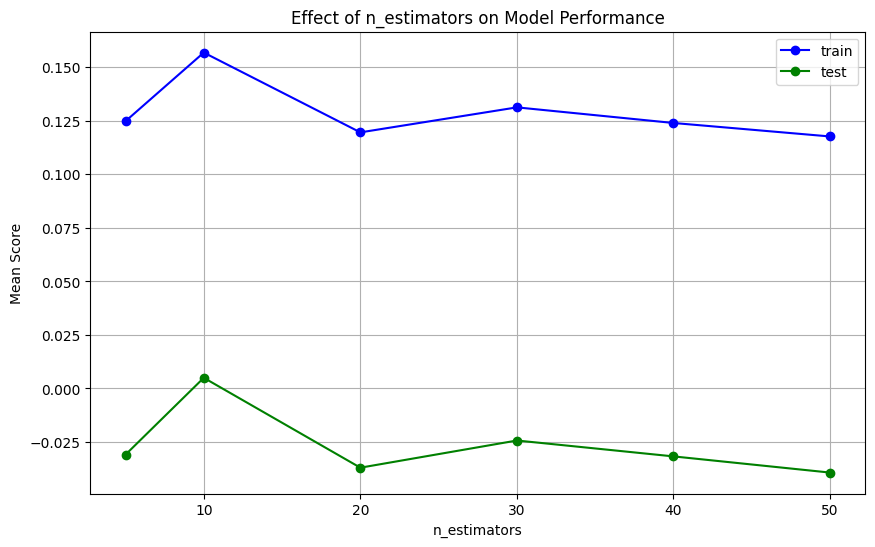

15


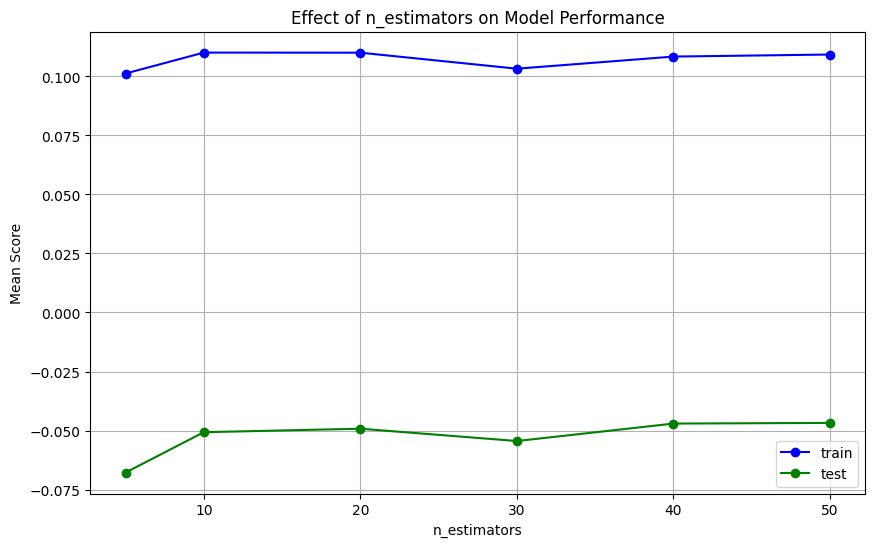

In [16]:
# eqi
delays = []
train_acc = []
test_acc = []
testsizes = []
best_grids = []
train_maes = []
train_mses = []
train_rmses = []
train_mapes = []
test_maes = []
test_mses = []
test_rmses = []
test_mapes = []


# no delay df_hourly
print("no delay")
X = df_hourly.drop(columns=['EQI', 'OCI'])
y_ = df_hourly['EQI']
test_s = 0.3
delays.append(0)
testsizes.append(test_s)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
best_grids.append(best_grid)
train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
train_acc.append(train_accuracy)
train_maes.append(train_mae)
train_mses.append(train_mse)
train_rmses.append(train_rmse)
train_mapes.append(train_mape)


test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
test_acc.append(test_accuracy)
test_maes.append(test_mae)
test_mses.append(test_mse)
test_rmses.append(test_rmse)
test_mapes.append(test_mape)
    
plot_results(grid_search, param='n_estimators')


for kk in list_hours_shifted:
    print(kk)
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_col_drop = ['EQI', 'OCI']
    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(list_col_drop)):
        for jj in range(1,kk_int+1):
            list_names_new.append(list_col_drop[ii]+str(jj))

    X = df_delay_16_hours_result.drop(columns=list_names_new)
    X = X.drop(columns=['EQI', 'OCI'])
    y_ = df_delay_16_hours_result['EQI']
    
    # check different test sizes
    test_s = 0.3
    delays.append(kk)
    testsizes.append(test_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_grid = grid_search.best_estimator_
    best_grids.append(best_grid)
    train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
    train_acc.append(train_accuracy)
    train_maes.append(train_mae)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_mapes.append(train_mape)


    test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
    test_acc.append(test_accuracy)
    test_maes.append(test_mae)
    test_mses.append(test_mse)
    test_rmses.append(test_rmse)
    test_mapes.append(test_mape)
    
    plot_results(grid_search, param='n_estimators')
    #plot_results(grid_search, param='max_depth')


df = pd.DataFrame.from_dict({
 'kk': delays,
 'test_size': testsizes,
 'grid': best_grids,
 'train_acc': train_acc,
 'test_acc': test_acc,
 'train_mae': train_maes,
 'test_mae': test_maes,
 'train_mse': train_mses,
 'test_mse': test_mses,
 'train_rmse': train_rmses,
 'test_rmse': test_rmses,
 'train_mape': train_mapes,
 'test_mape': test_mapes
 })

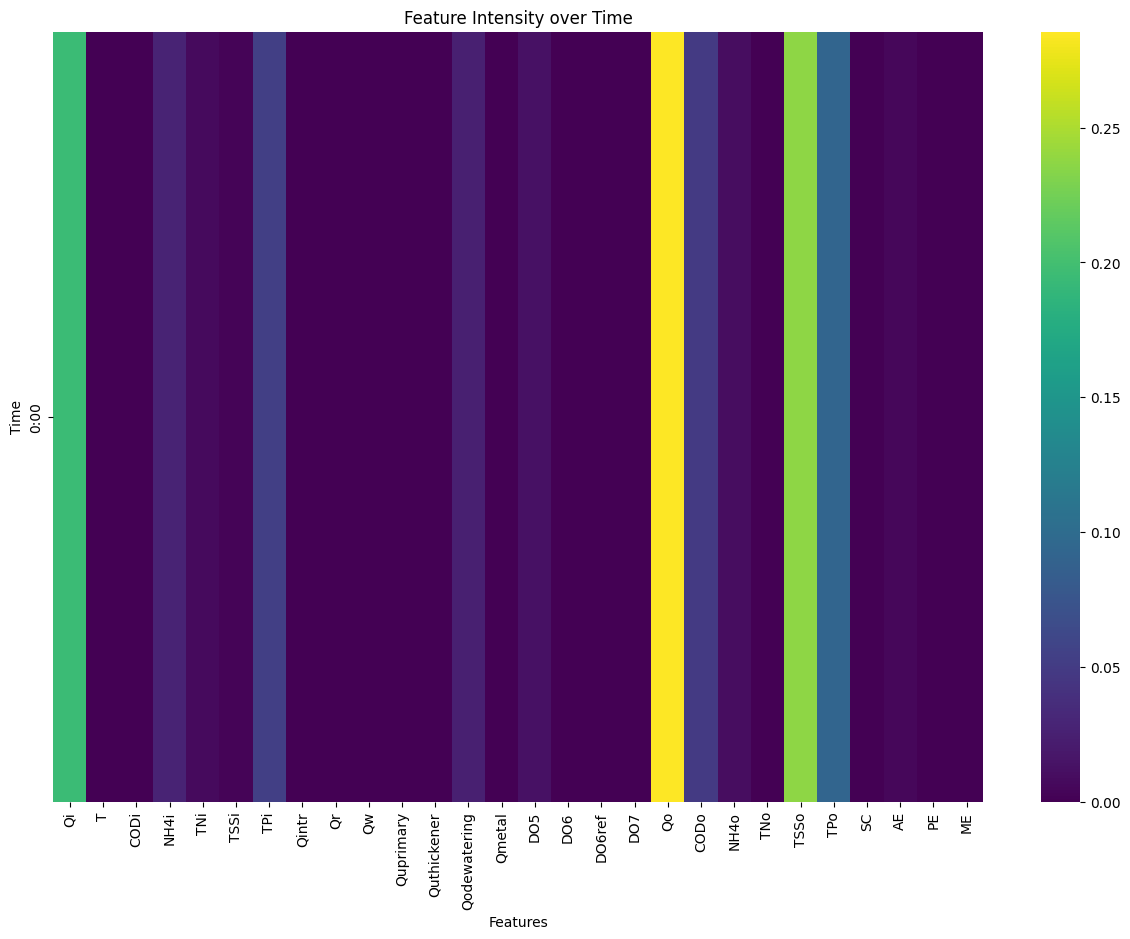

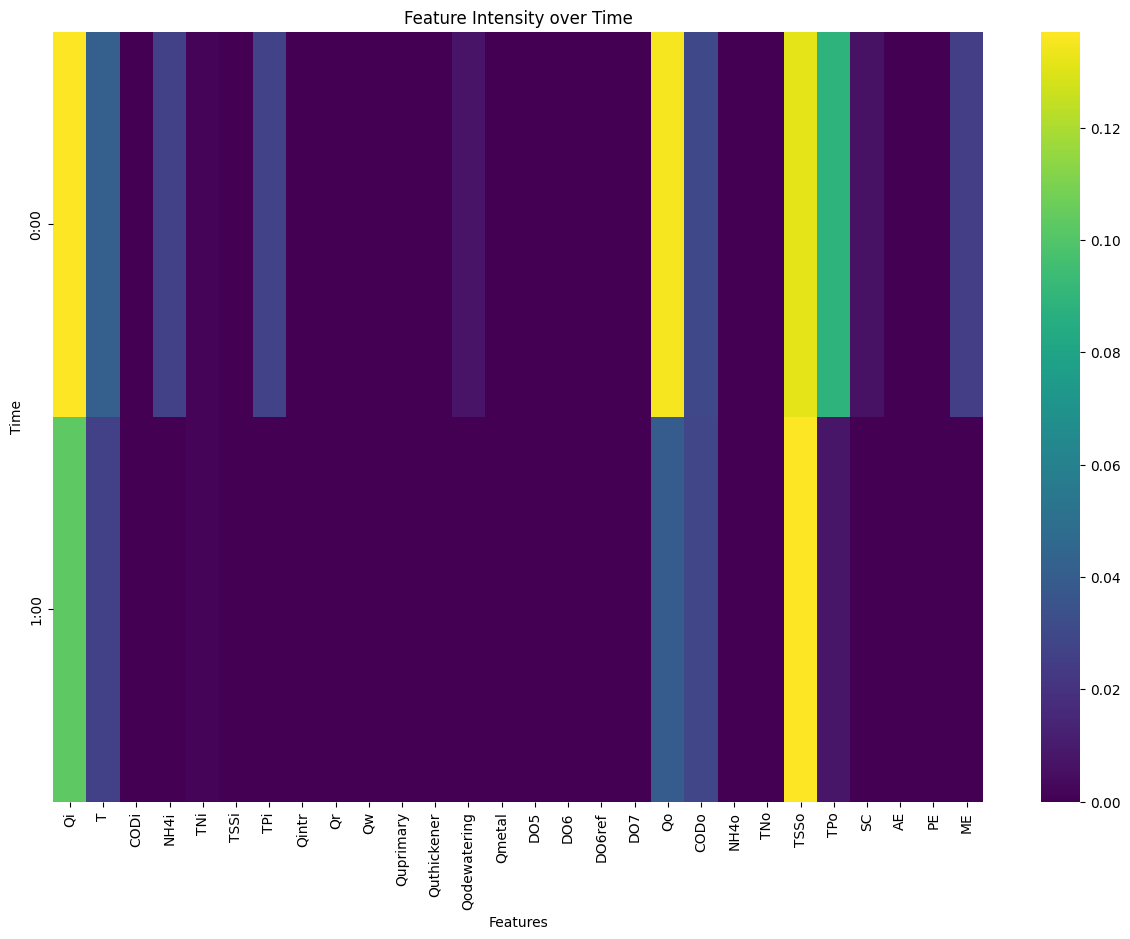

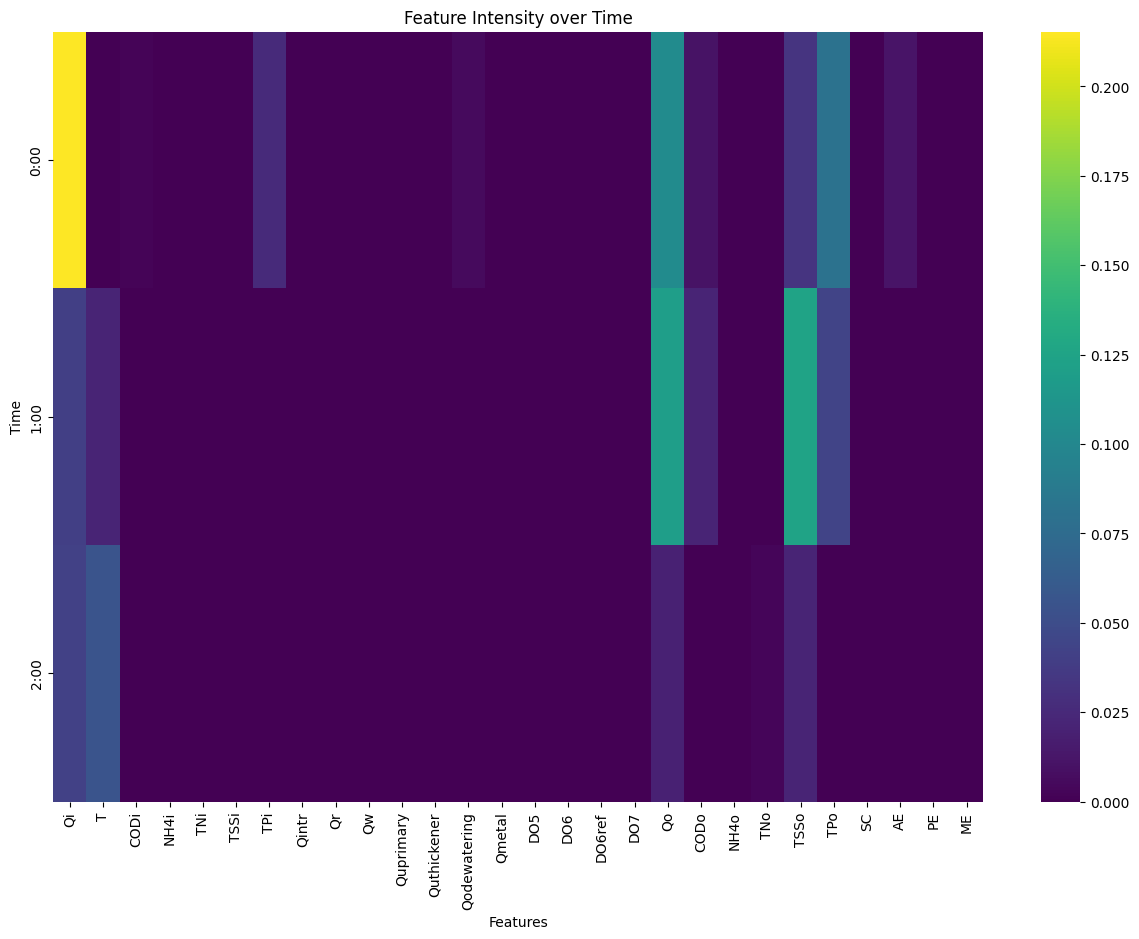

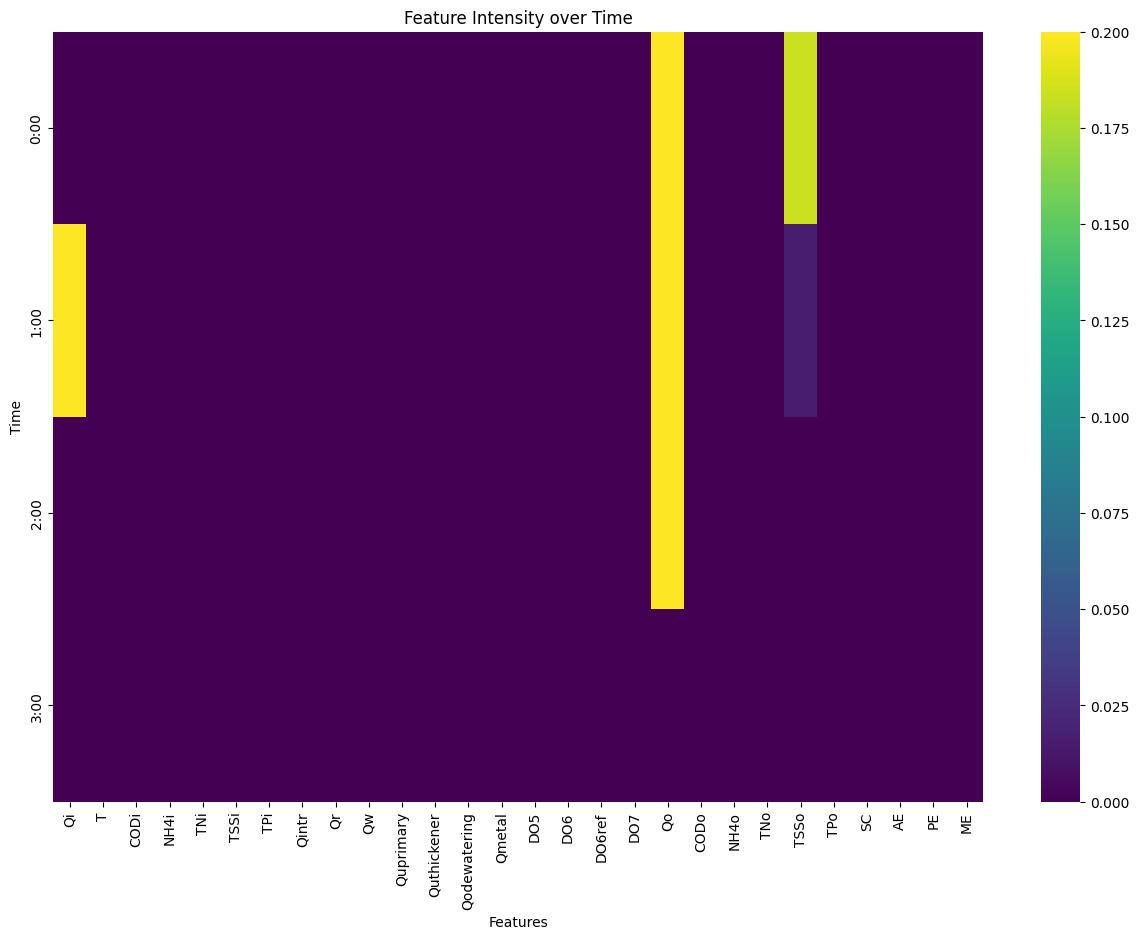

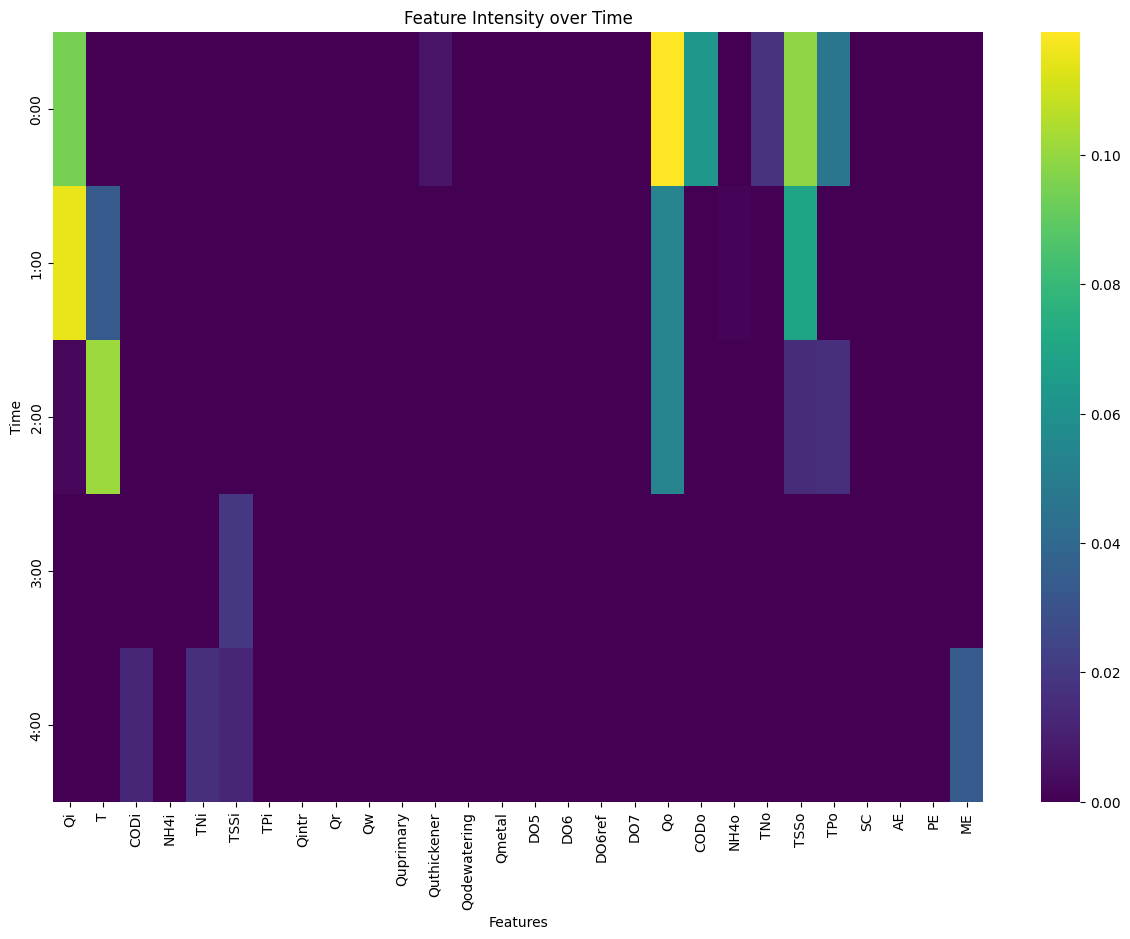

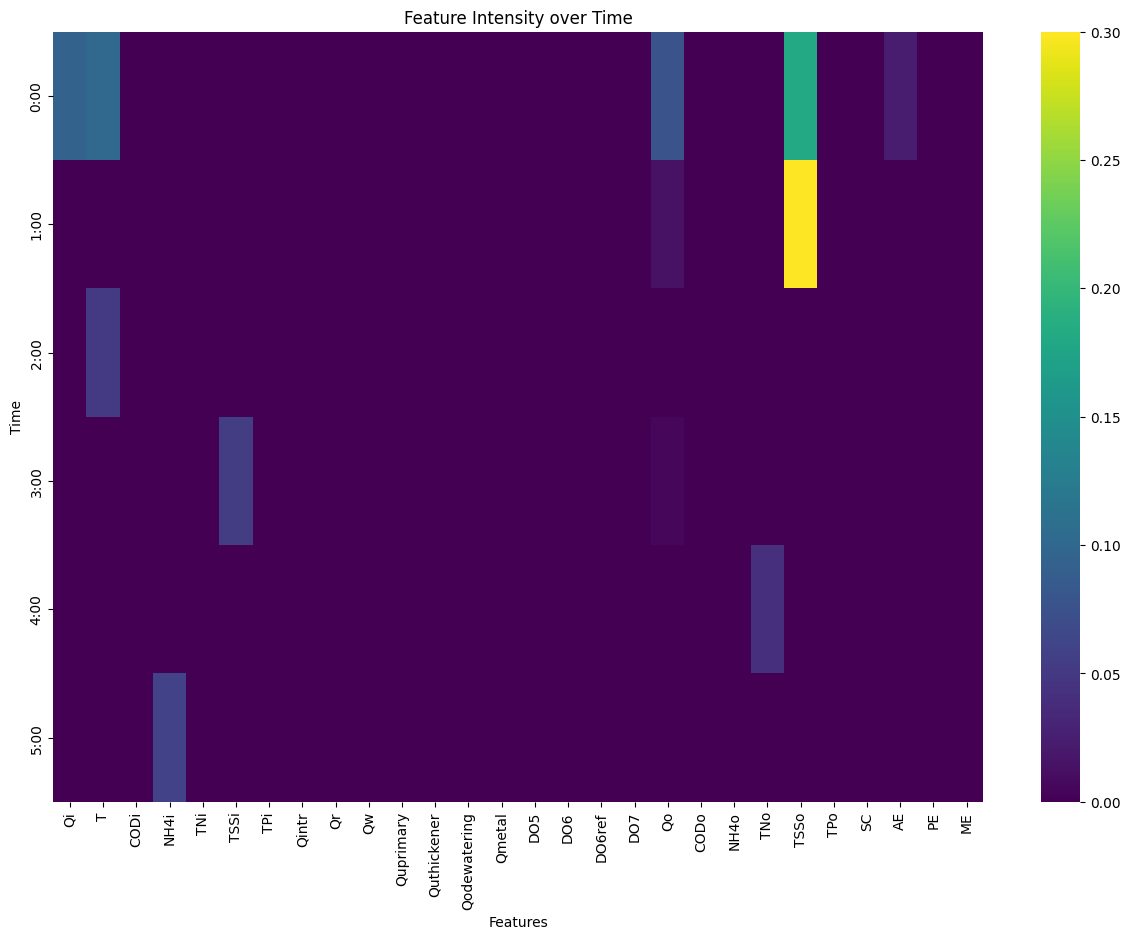

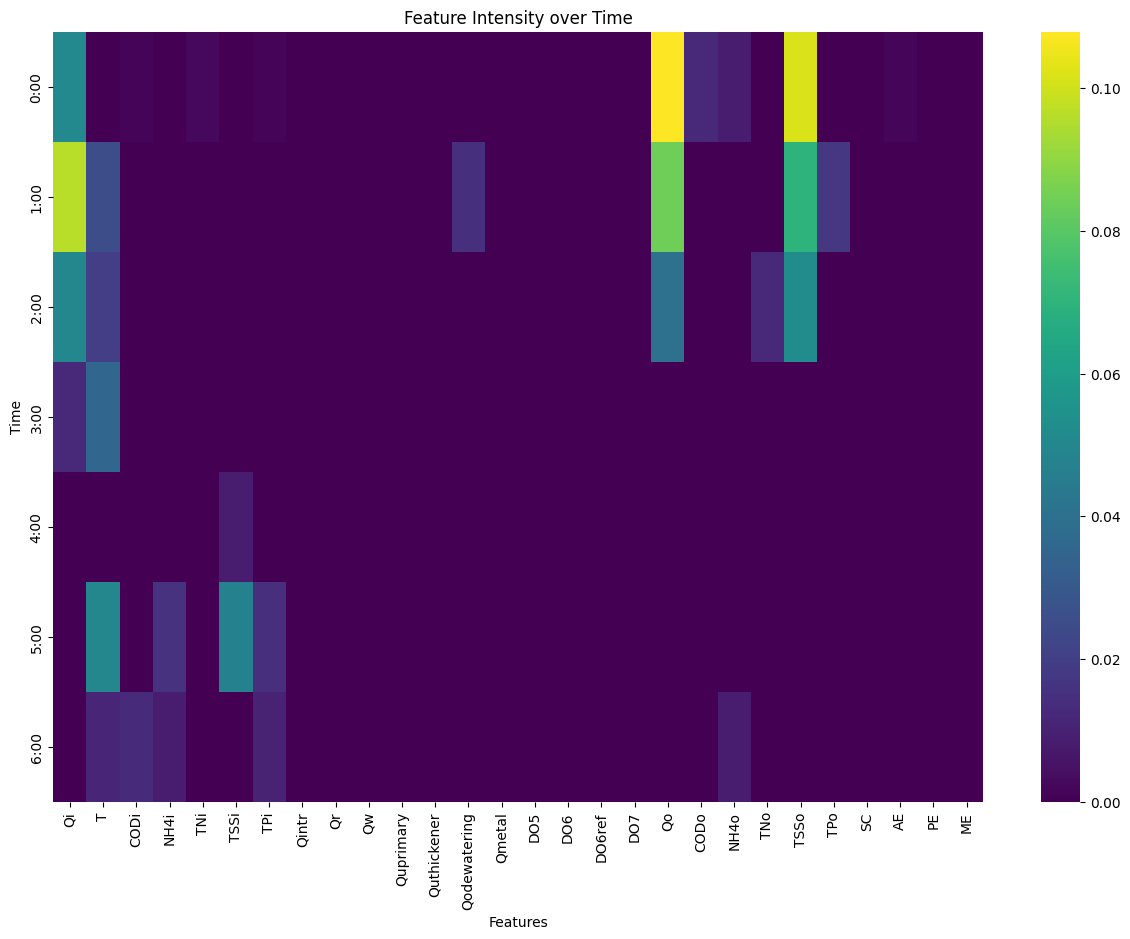

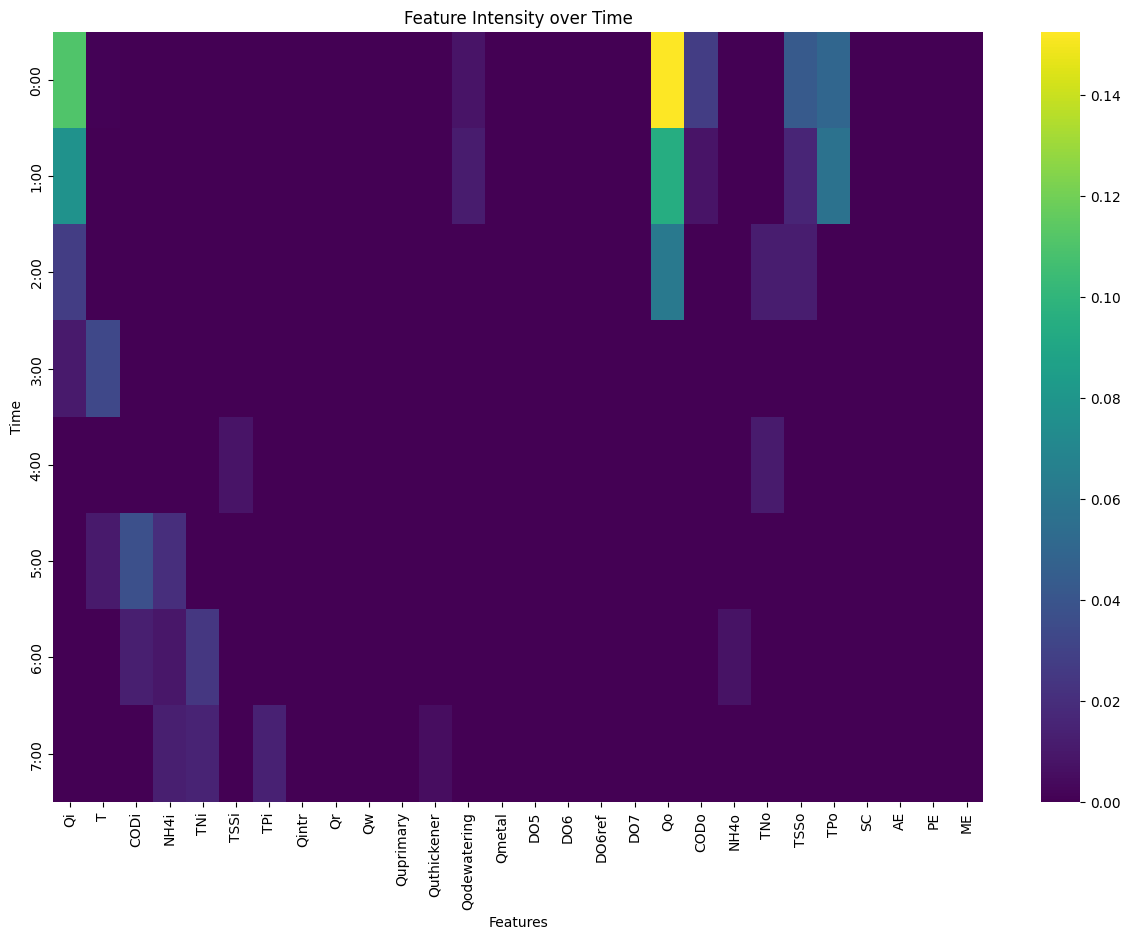

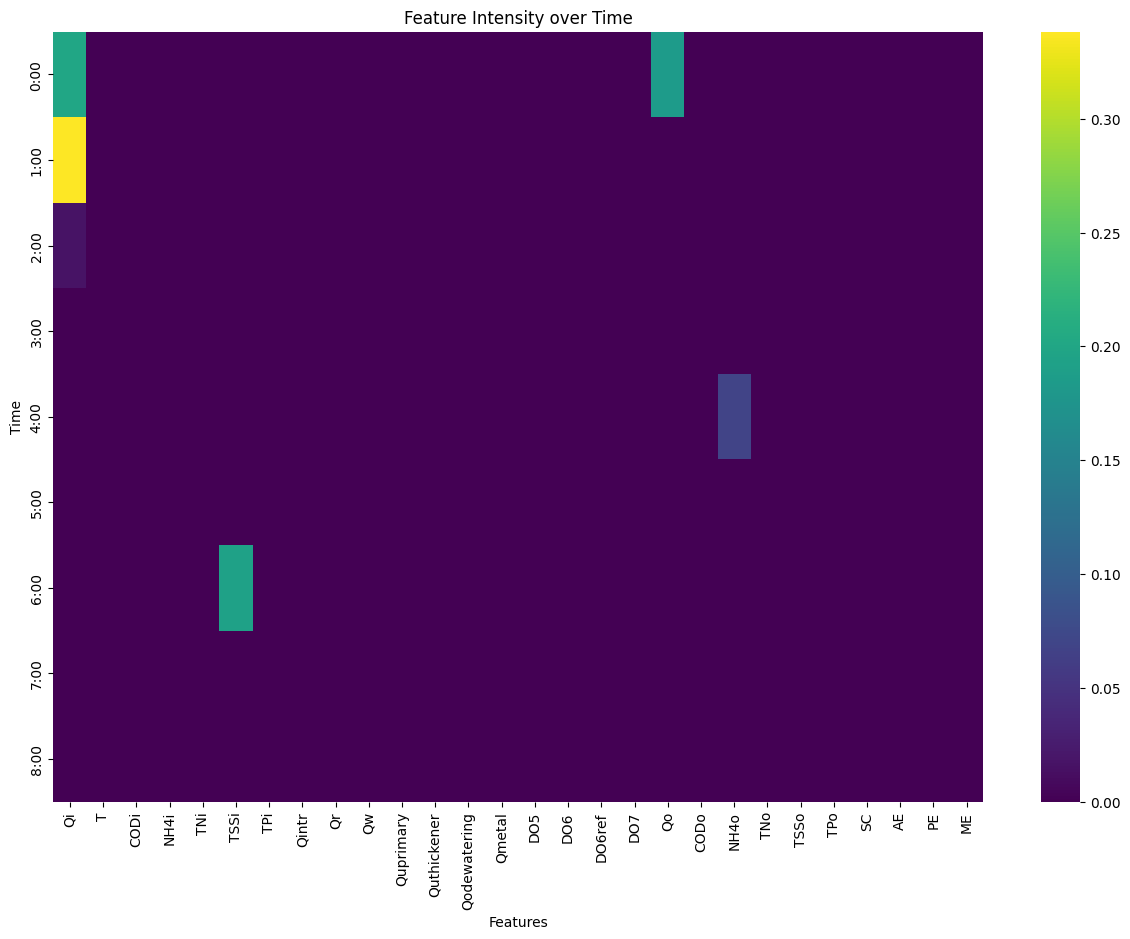

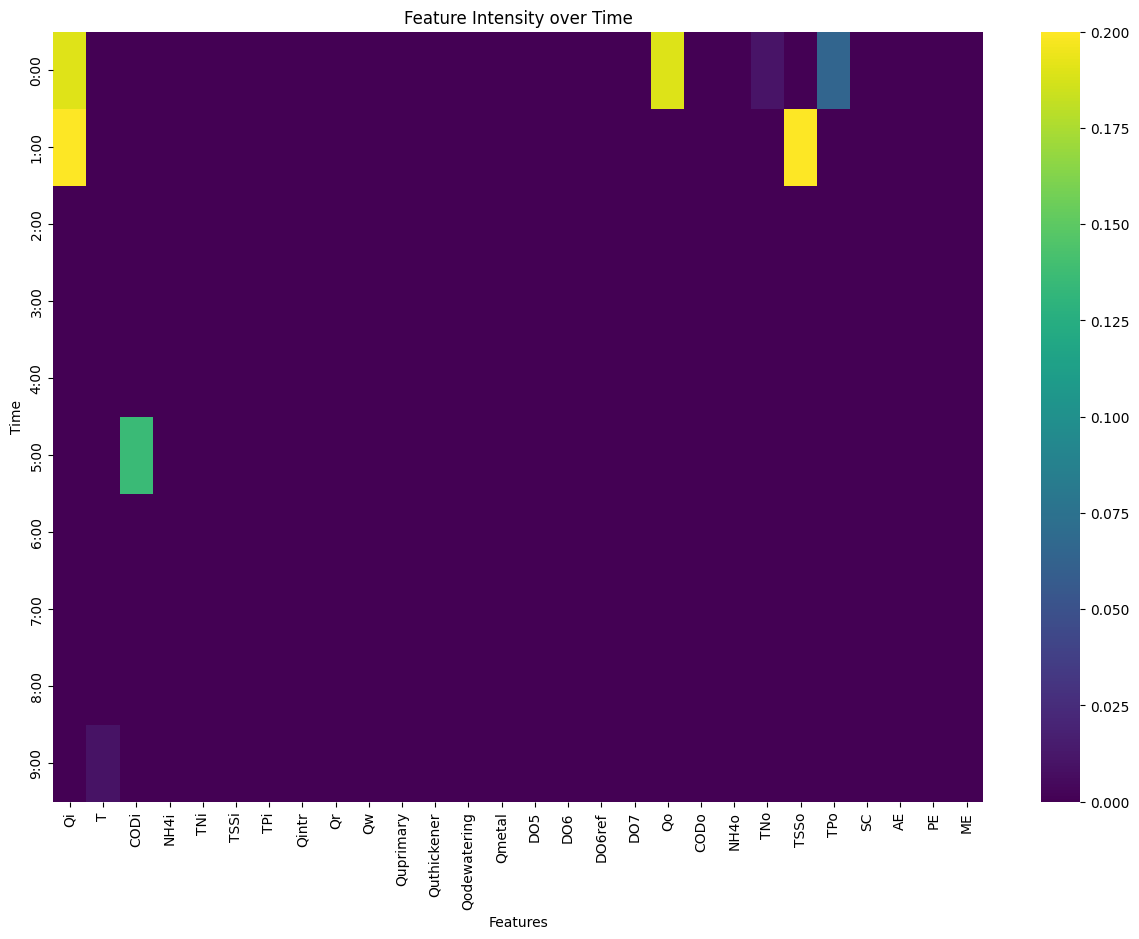

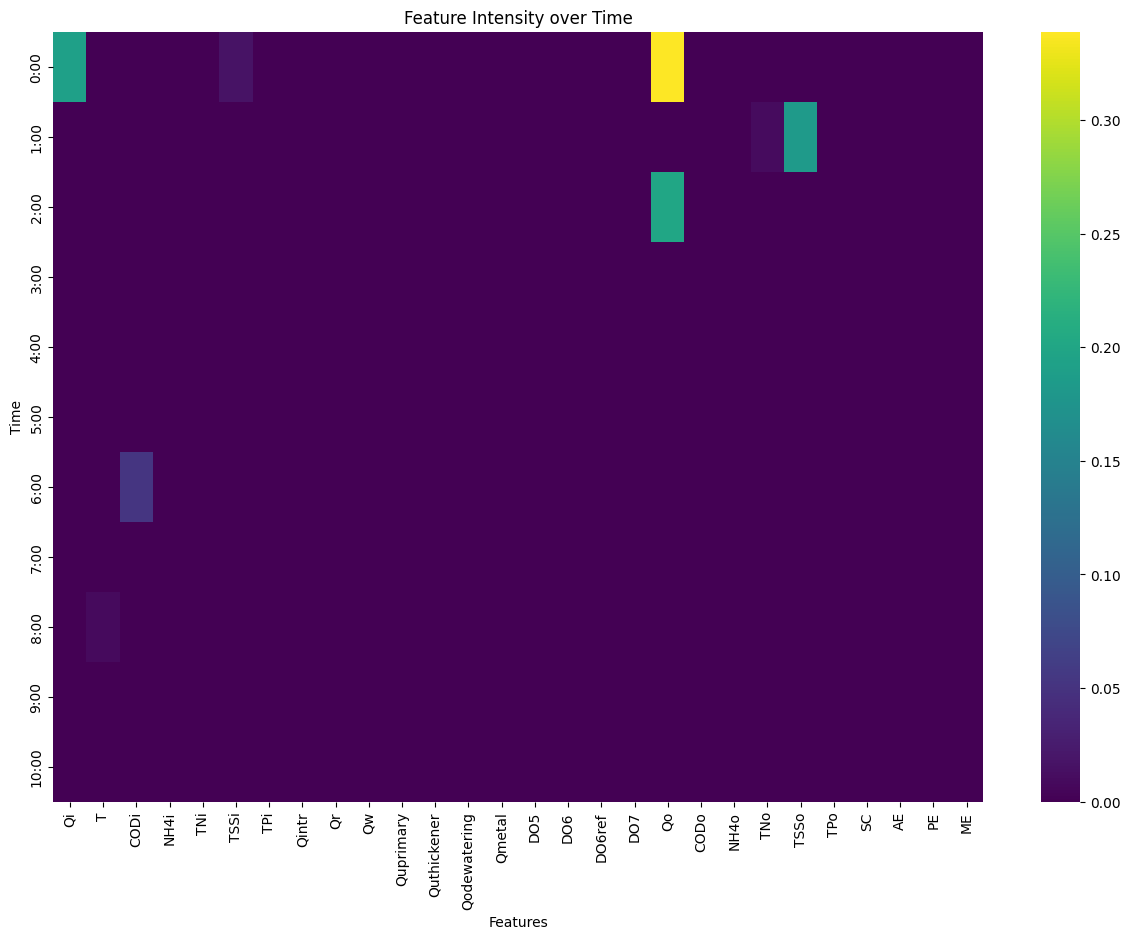

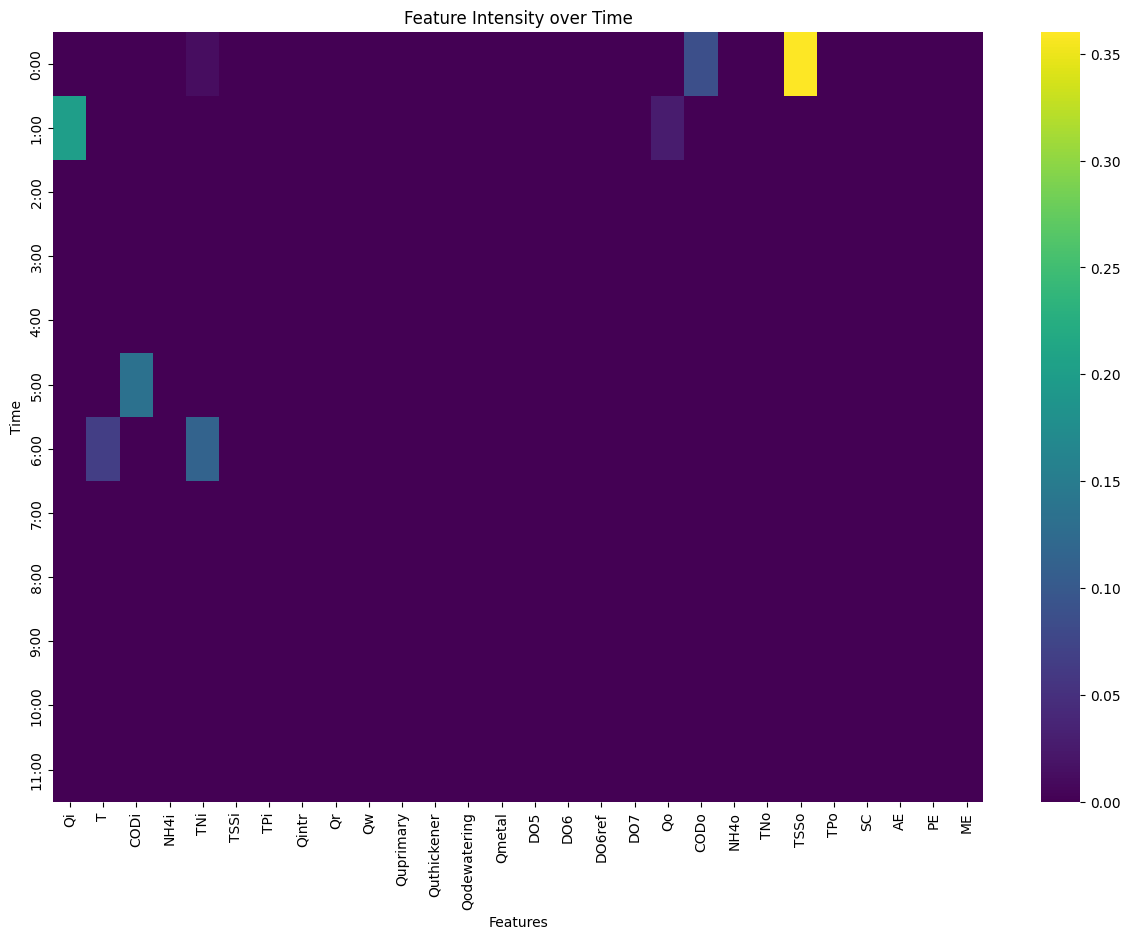

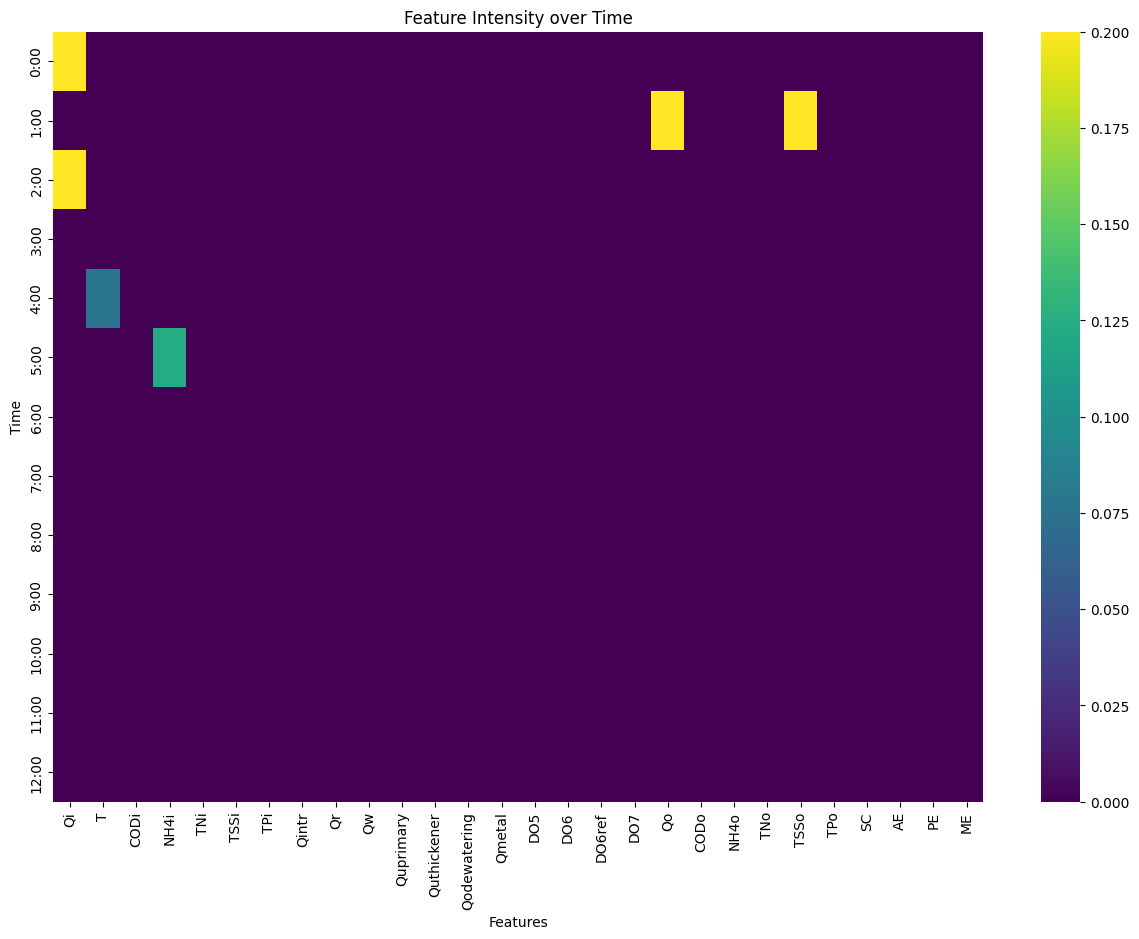

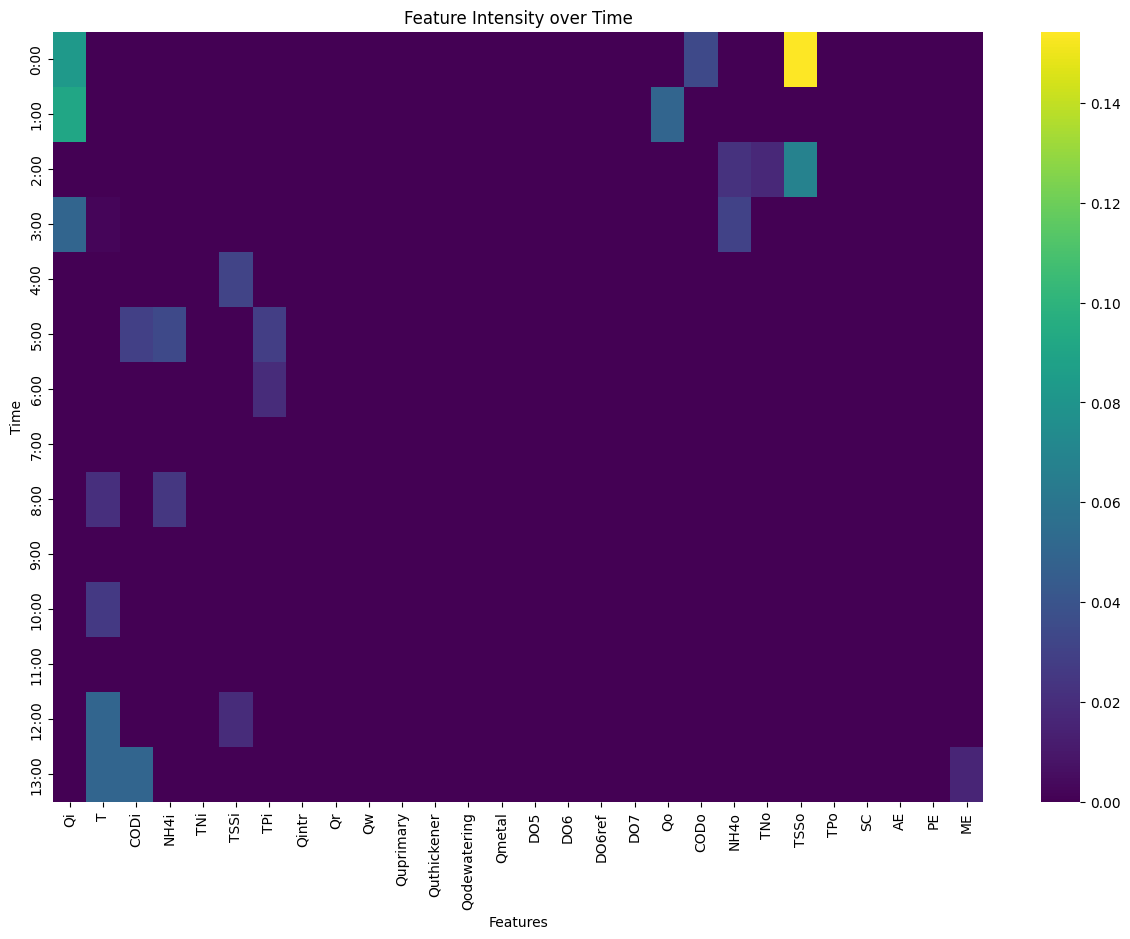

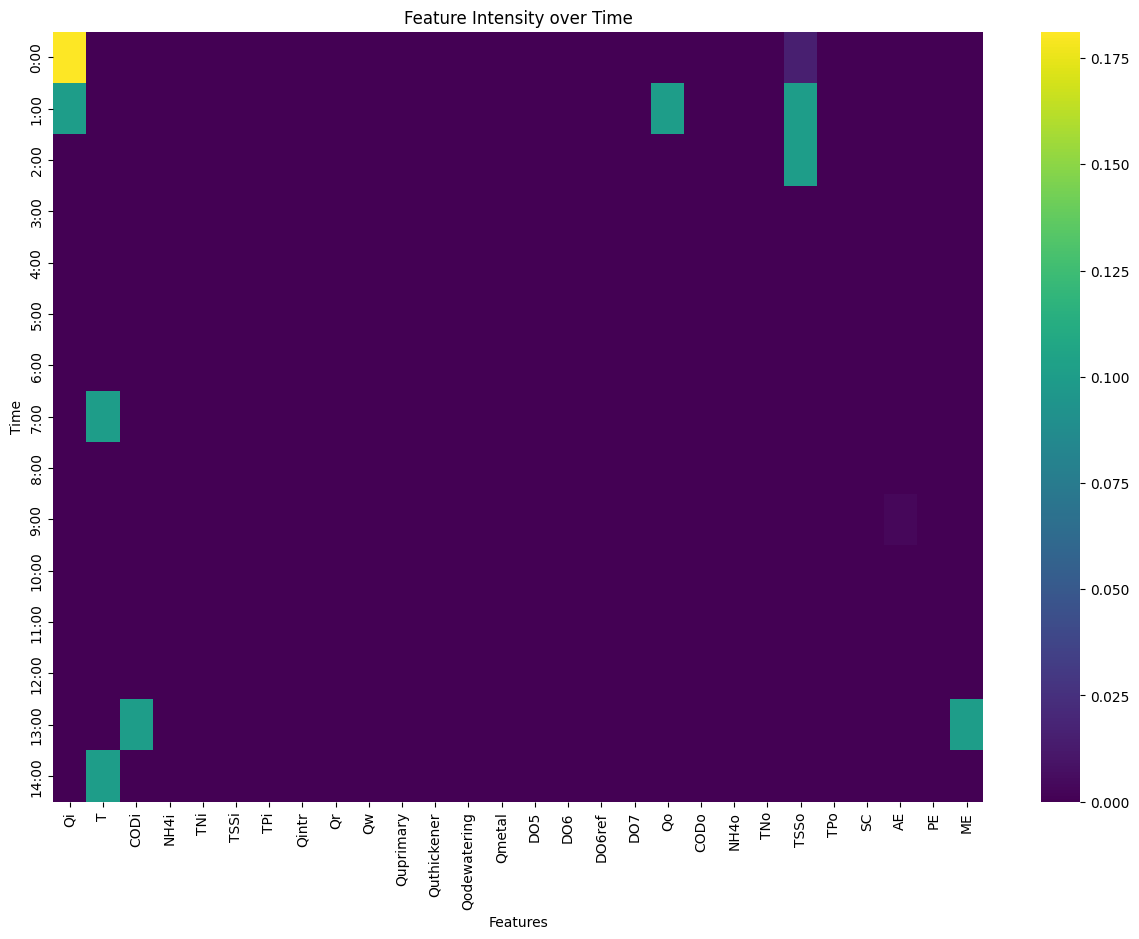

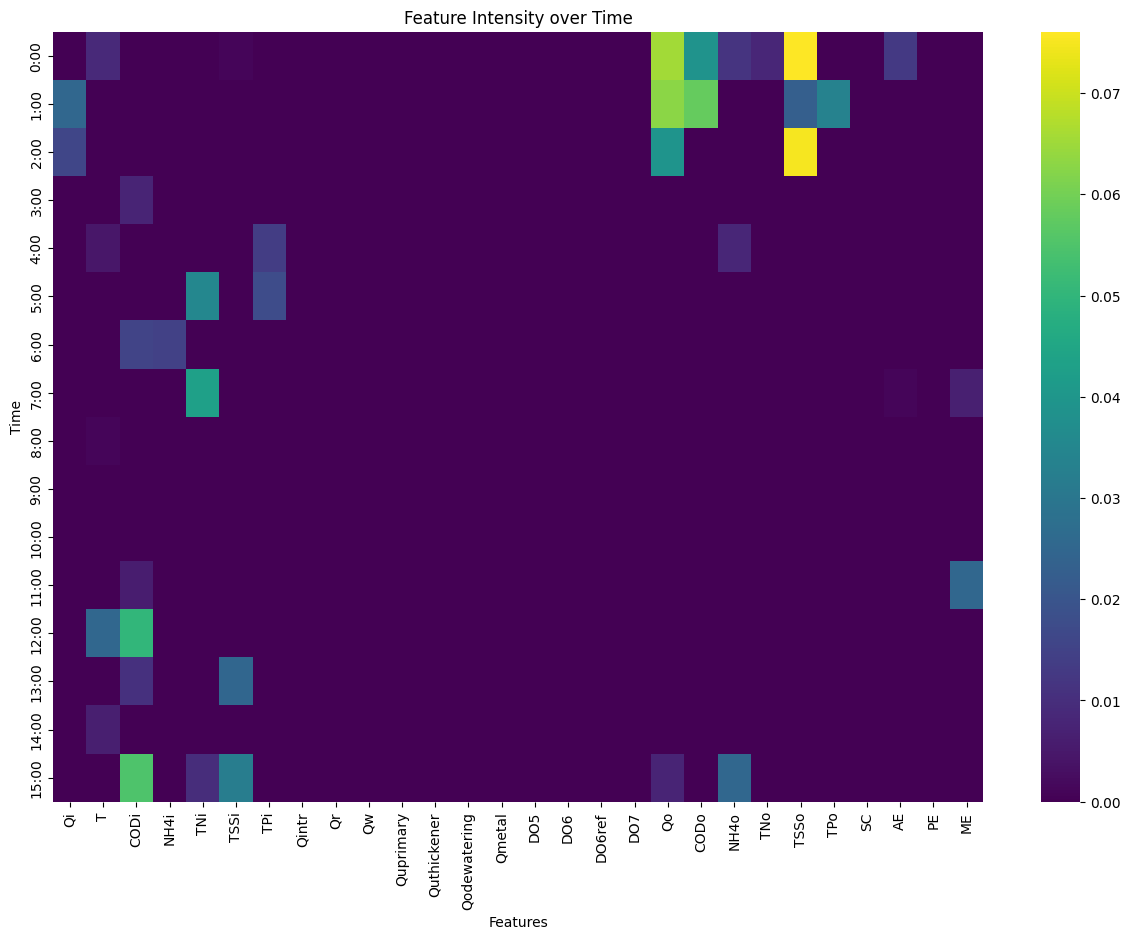

In [17]:
# eqi
n_features = 28

kk = 0
df_ = df[df['kk'] == kk]
X = df_hourly.drop(columns=['EQI', 'OCI'])
y_ = df_hourly['EQI']

X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.1, shuffle=False)

model = df_.iloc[0]['grid']
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

importances = model.feature_importances_

np.random.seed(0)
data = importances.reshape(int(kk)+1, 28)

# Create time and feature labels for the axes
time_labels = [f"{i}:00" for i in range(data.shape[0])]
feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

# Adding titles and labels
plt.title("Feature Intensity over Time")
plt.xlabel("Features")
plt.ylabel("Time")

# Show the plot
plt.show()

for kk in list_hours_shifted:
    df_ = df[df['kk'] == kk]
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_col_drop = ['EQI', 'OCI']
    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(list_col_drop)):
        for jj in range(1,kk_int+1):
            list_names_new.append(list_col_drop[ii]+str(jj))

    X = df_delay_16_hours_result.drop(columns=list_names_new)
    X = X.drop(columns=['EQI', 'OCI'])
    y_ = df_delay_16_hours_result['EQI']


    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, shuffle=False)

    model = df_.iloc[0]['grid']
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    importances = model.feature_importances_
    
    np.random.seed(0)
    data = importances.reshape(int(kk)+1, 28)

    # Create time and feature labels for the axes
    time_labels = [f"{i}:00" for i in range(data.shape[0])]
    feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

    # Create the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

    # Adding titles and labels
    plt.title("Feature Intensity over Time")
    plt.xlabel("Features")
    plt.ylabel("Time")

    # Show the plot
    plt.show()

## Reducing number of features which we input to the model

In [18]:
features = ["Qi", "CODi", "NH4i", "TNi", "TSSi", "TPi", "Qo", "CODo", "NH4o", "TNo", "TSSo", "TPo"] # features to keep

no delay


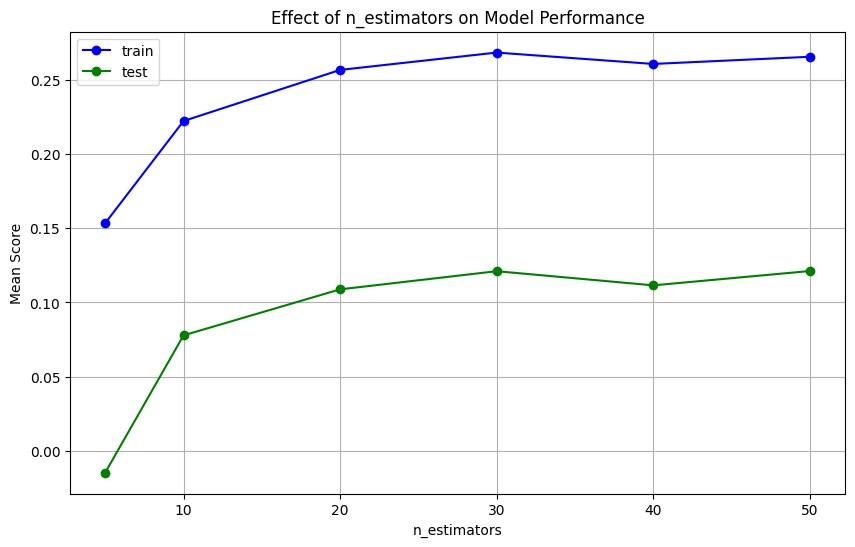

1


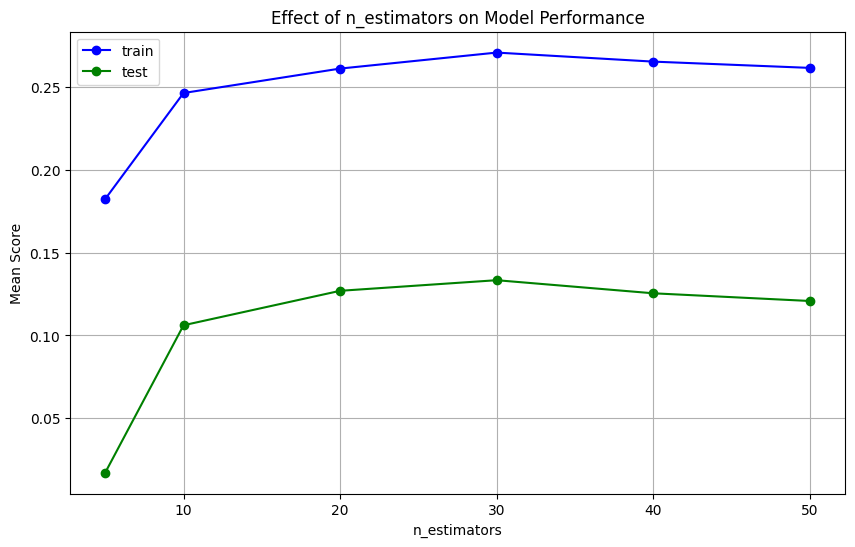

2


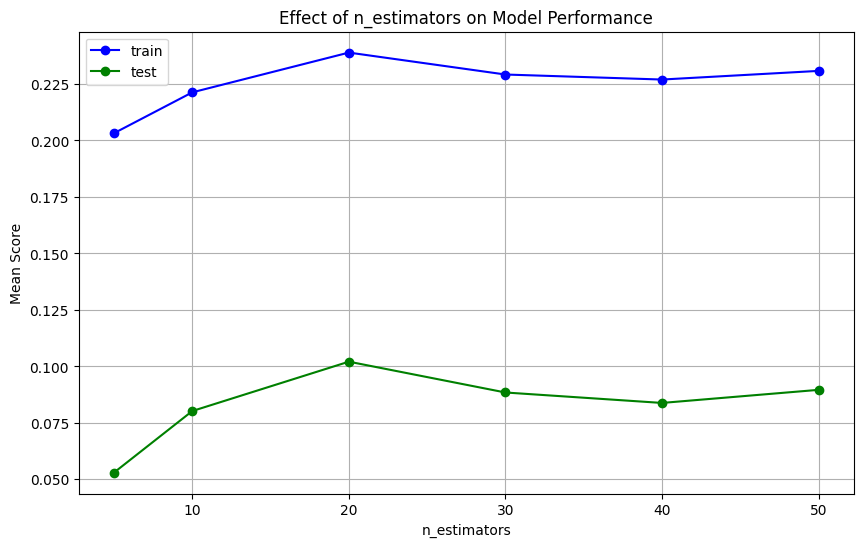

3


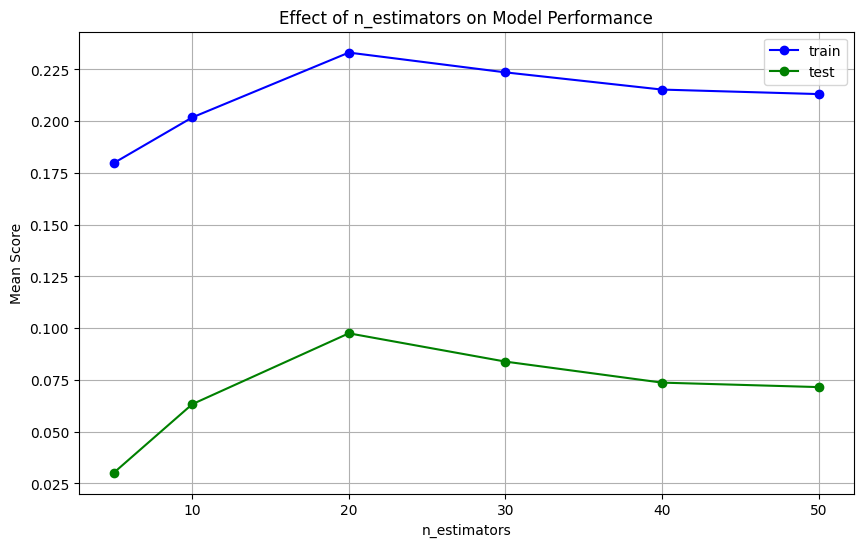

4


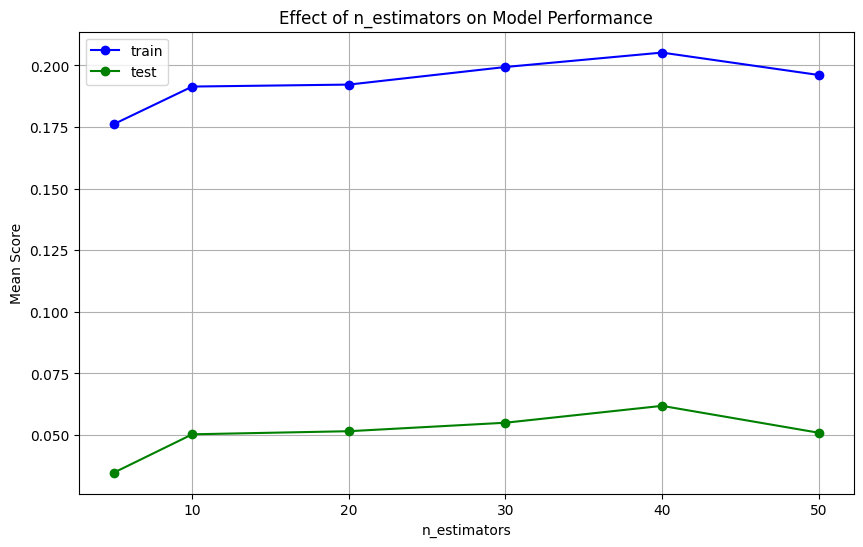

5


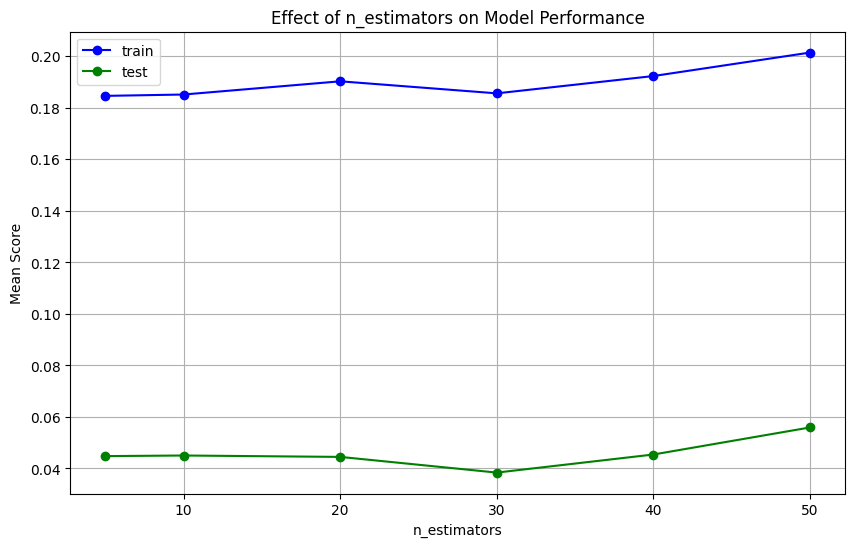

6


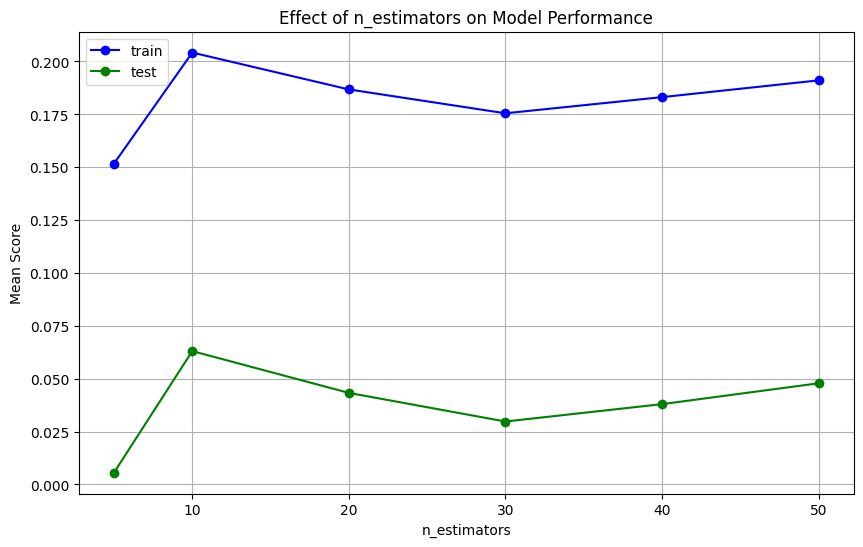

7


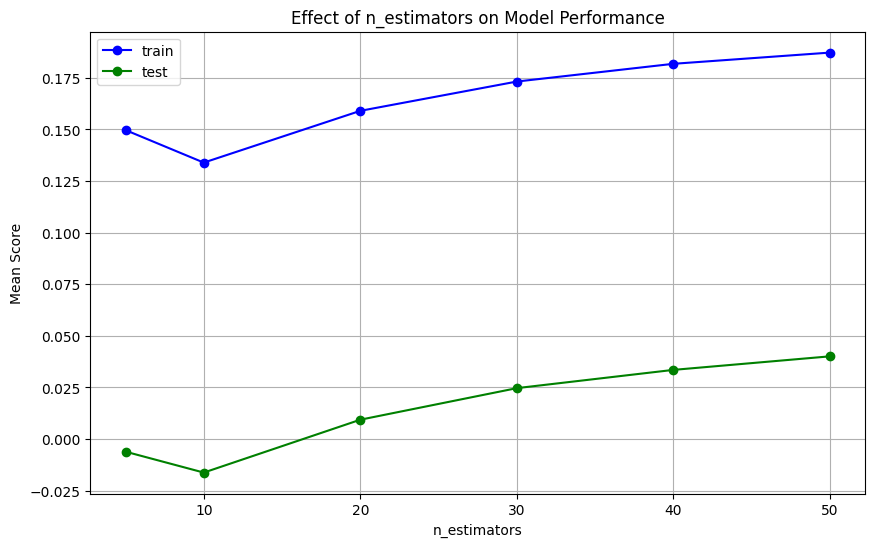

8


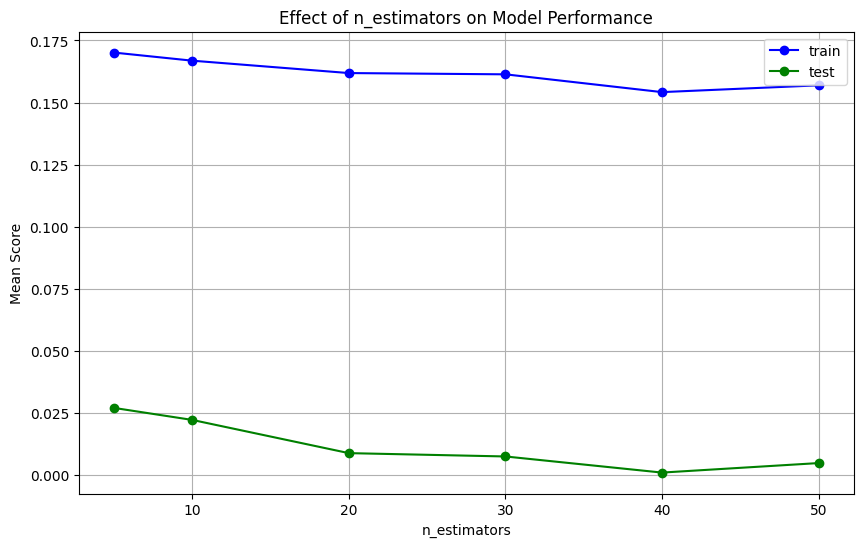

9


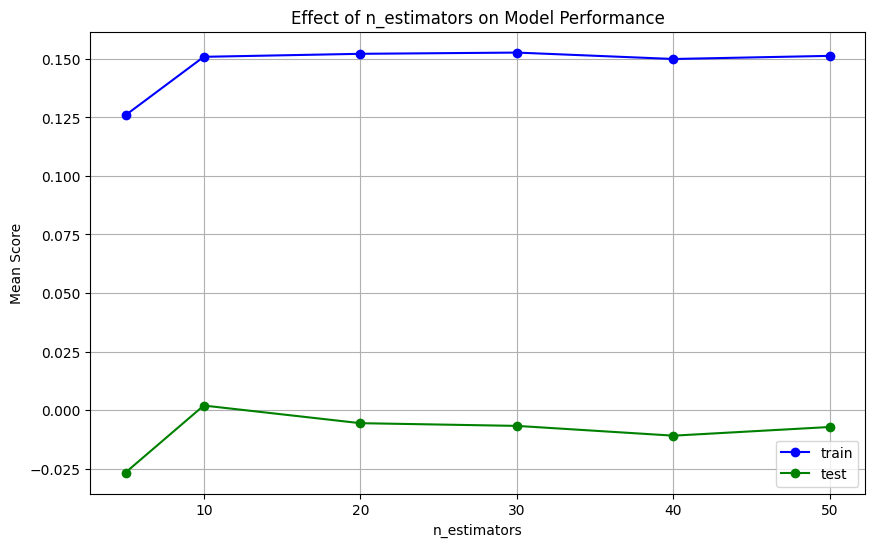

10


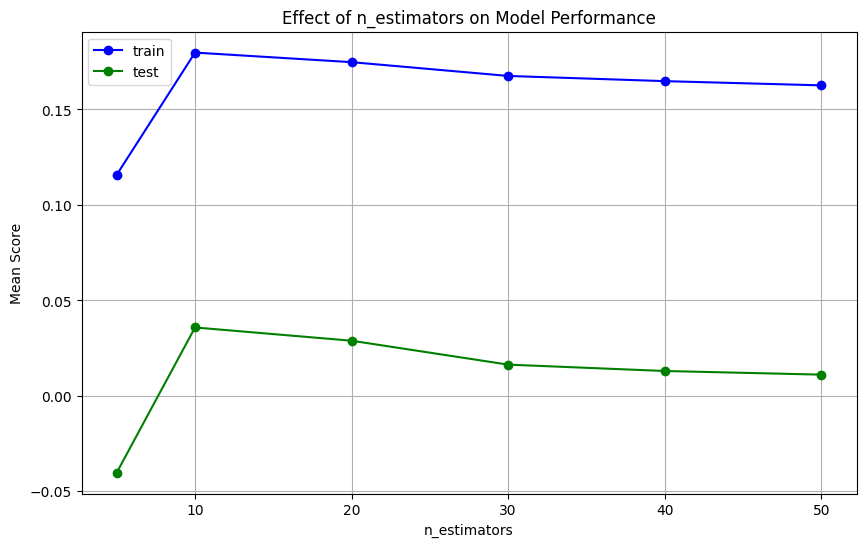

11


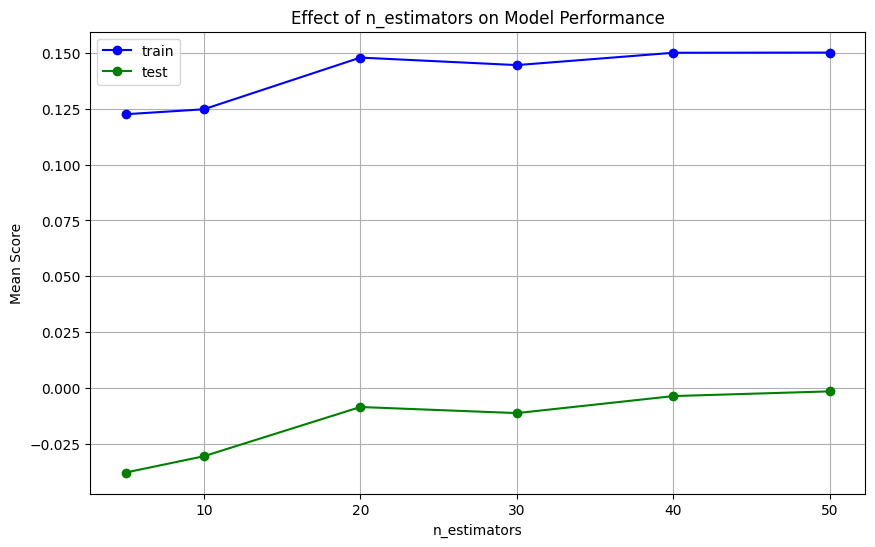

12


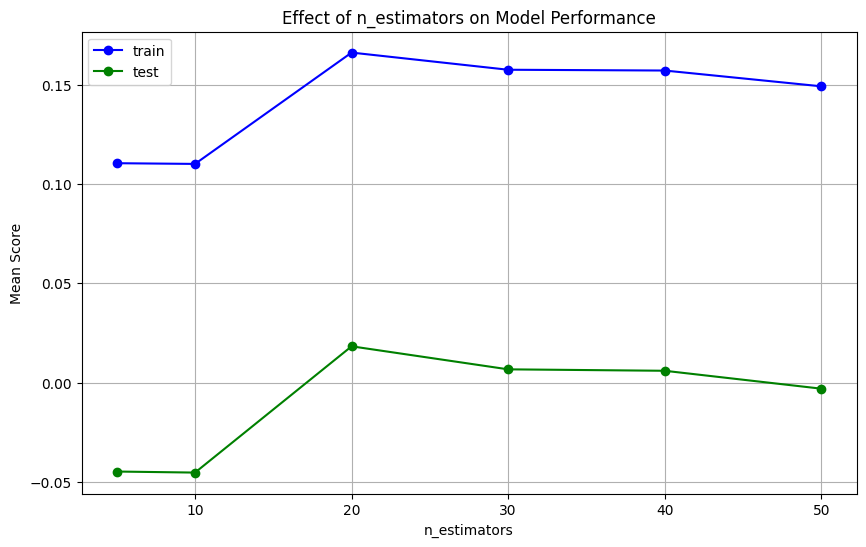

13


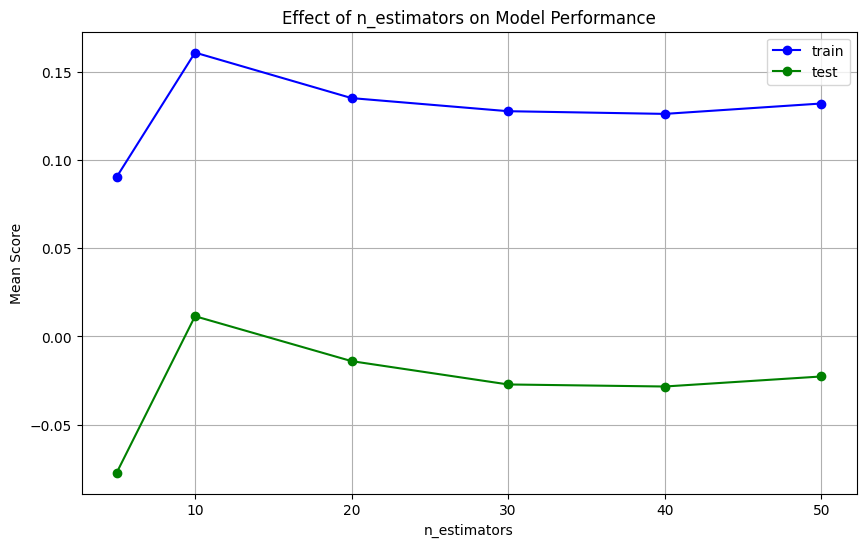

14


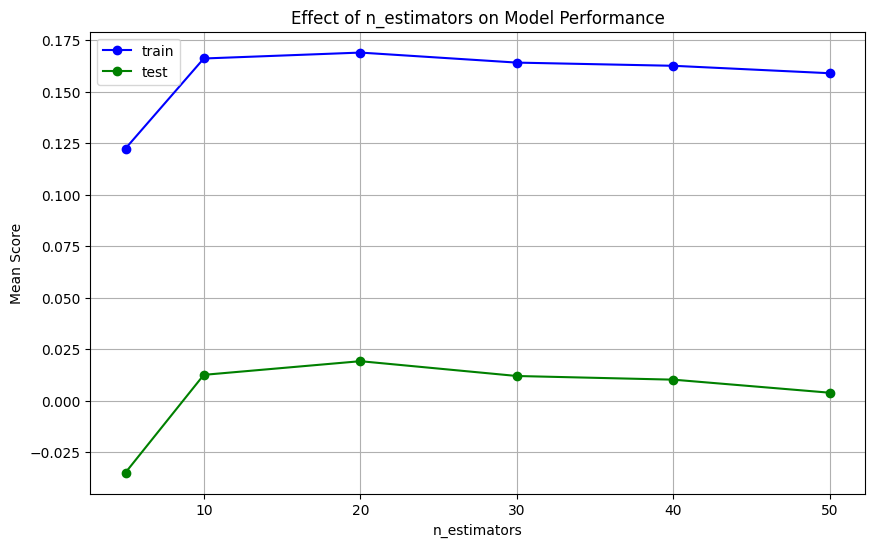

15


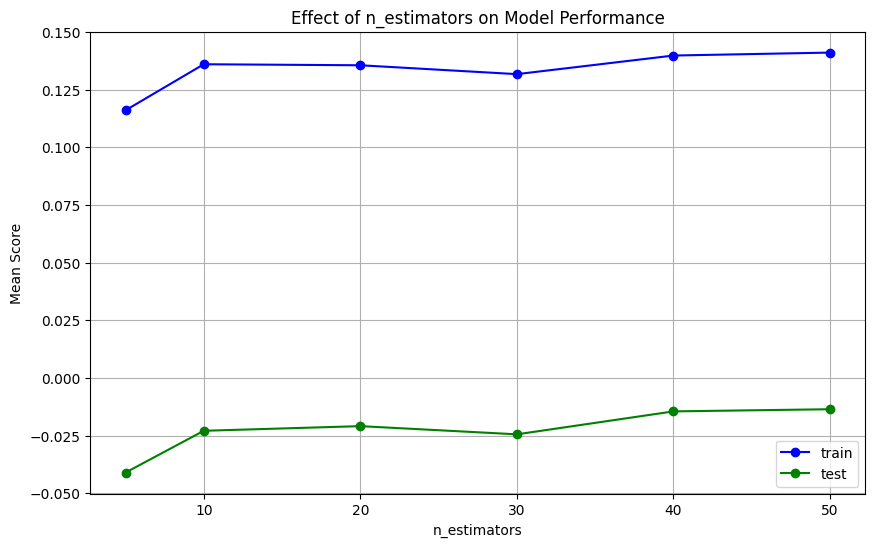

In [32]:
# eqi
delays = []
train_acc = []
test_acc = []
testsizes = []
best_grids = []
train_maes = []
train_mses = []
train_rmses = []
train_mapes = []
test_maes = []
test_mses = []
test_rmses = []
test_mapes = []

columns_to_drop = set(df_hourly.columns) - set(features)
columns_to_drop = list(columns_to_drop)


# no delay df_hourly
print("no delay")
X = df_hourly.drop(columns=columns_to_drop)
y_ = df_hourly['EQI']

test_s = 0.3
delays.append(0)
testsizes.append(test_s)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
best_grids.append(best_grid)
train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
train_acc.append(train_accuracy)
train_maes.append(train_mae)
train_mses.append(train_mse)
train_rmses.append(train_rmse)
train_mapes.append(train_mape)


test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
test_acc.append(test_accuracy)
test_maes.append(test_mae)
test_mses.append(test_mse)
test_rmses.append(test_rmse)
test_mapes.append(test_mape)
    
plot_results(grid_search, param='n_estimators')


for kk in list_hours_shifted:
    print(kk)
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(columns_to_drop)):
        for jj in range(0,kk_int+1):
            if jj==0:
                list_names_new.append(columns_to_drop[ii])
            else:
                list_names_new.append(columns_to_drop[ii]+str(jj))
    
    y_ = df_delay_16_hours_result['EQI']
    X = df_delay_16_hours_result.drop(columns=list_names_new)
    
    # check different test sizes
    test_s = 0.3
    delays.append(kk)
    testsizes.append(test_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=test_s, shuffle=False)

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_grid = grid_search.best_estimator_
    best_grids.append(best_grid)
    train_accuracy, train_mae, train_mse, train_rmse, train_mape = evaluate(best_grid, X_train, y_train)
    train_acc.append(train_accuracy)
    train_maes.append(train_mae)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_mapes.append(train_mape)


    test_accuracy, test_mae, test_mse, test_rmse, test_mape = evaluate(best_grid, X_test, y_test)
    test_acc.append(test_accuracy)
    test_maes.append(test_mae)
    test_mses.append(test_mse)
    test_rmses.append(test_rmse)
    test_mapes.append(test_mape)
    
    plot_results(grid_search, param='n_estimators')
    #plot_results(grid_search, param='max_depth')


df = pd.DataFrame.from_dict({
 'kk': delays,
 'test_size': testsizes,
 'grid': best_grids,
 'train_acc': train_acc,
 'test_acc': test_acc,
 'train_mae': train_maes,
 'test_mae': test_maes,
 'train_mse': train_mses,
 'test_mse': test_mses,
 'train_rmse': train_rmses,
 'test_rmse': test_rmses,
 'train_mape': train_mapes,
 'test_mape': test_mapes
 })

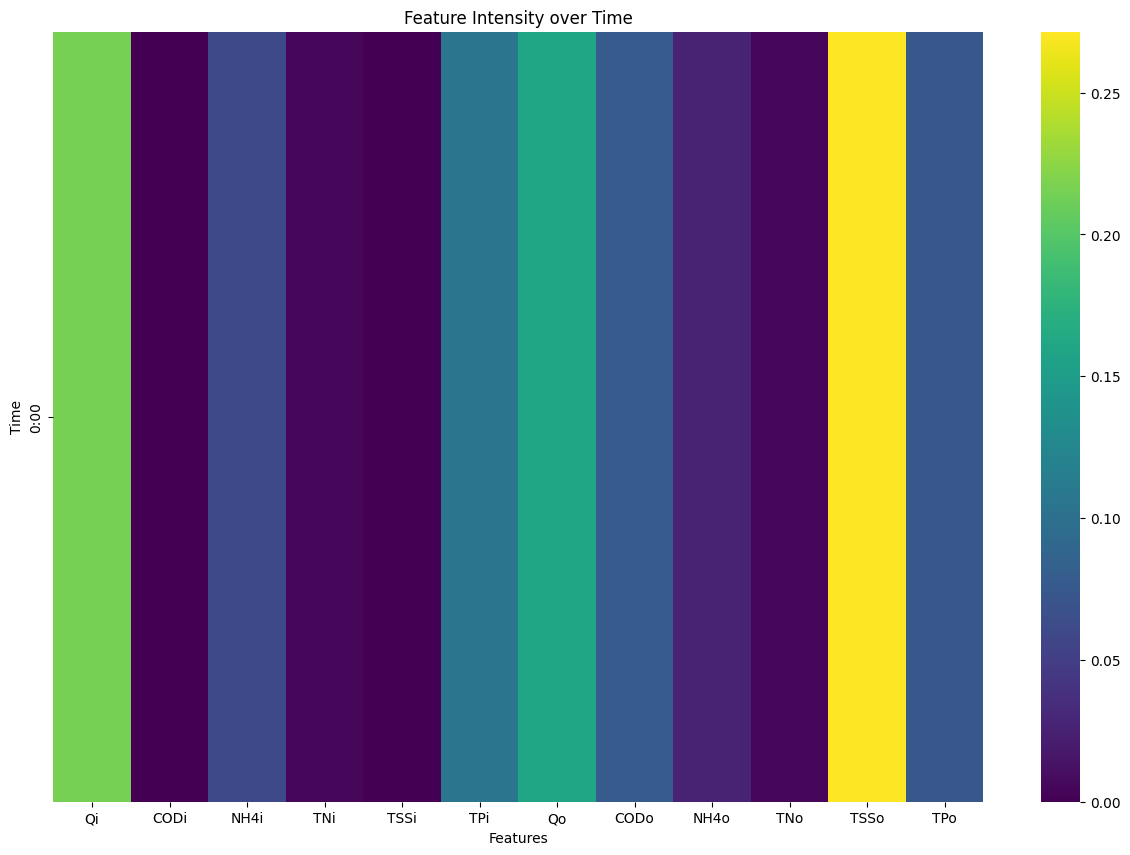

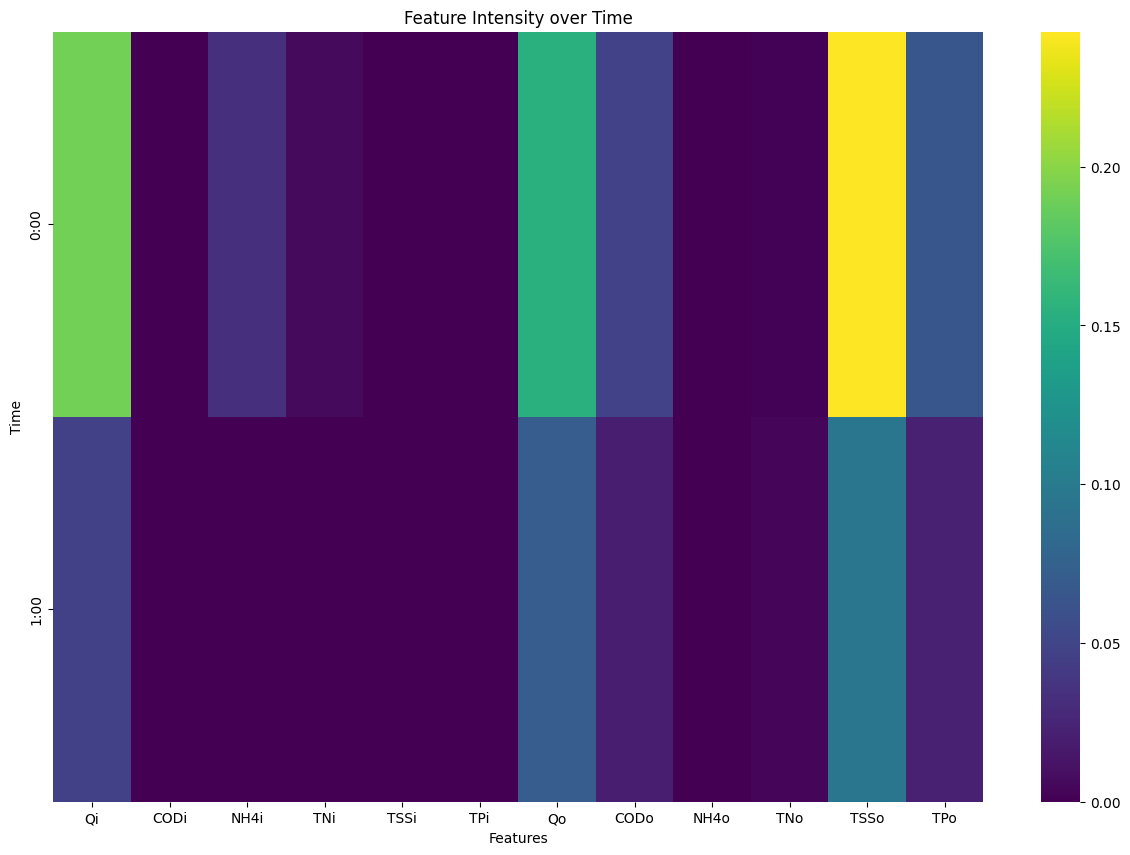

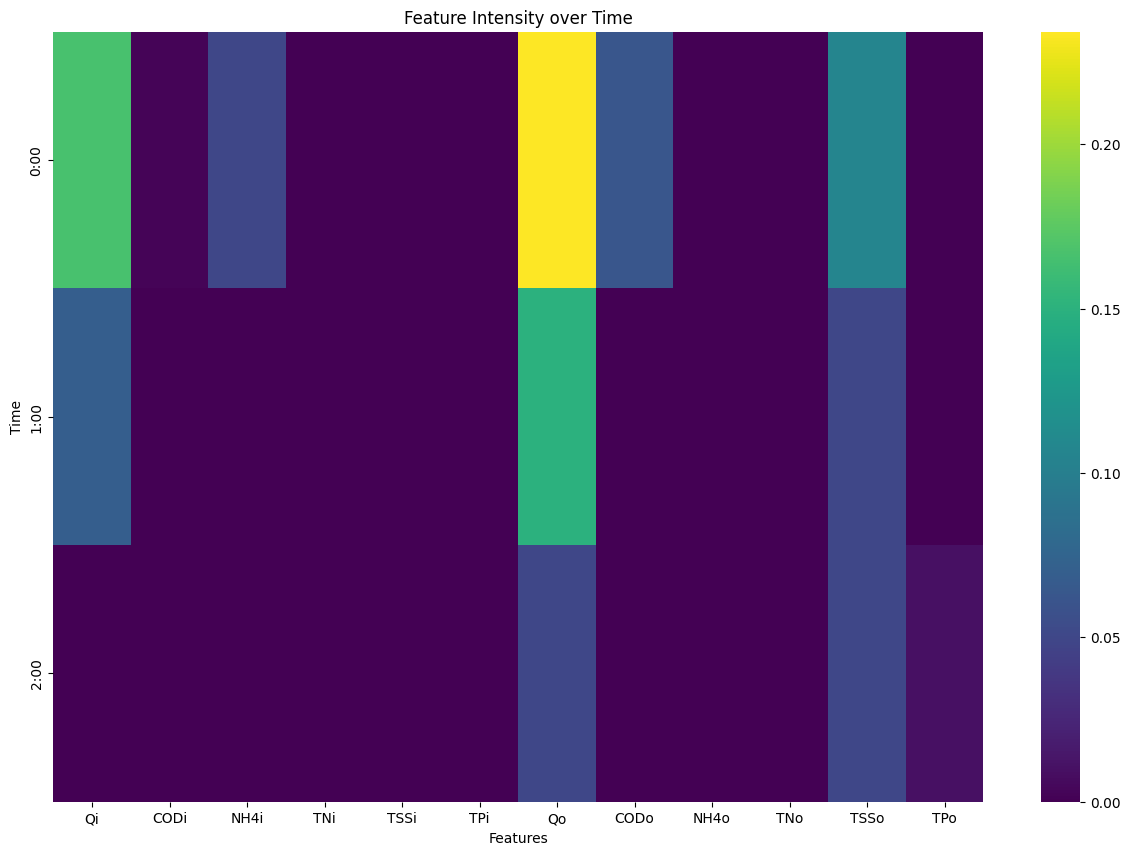

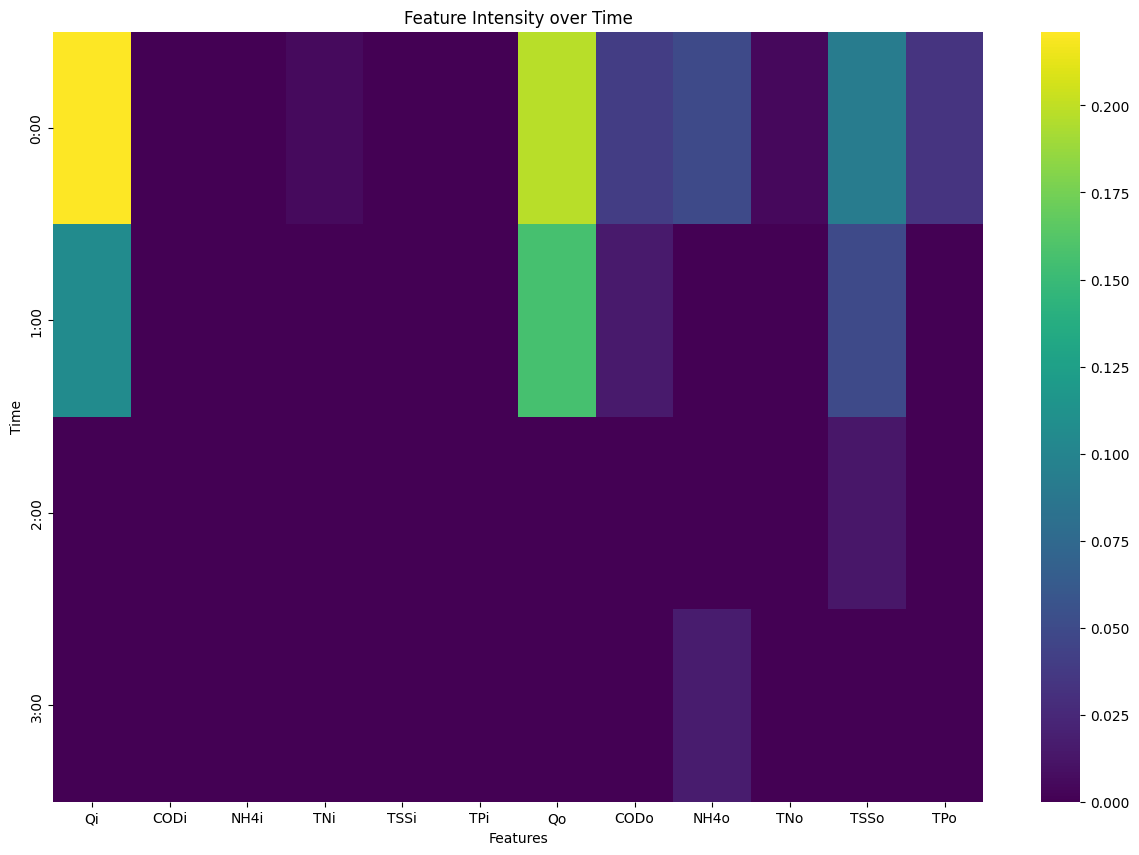

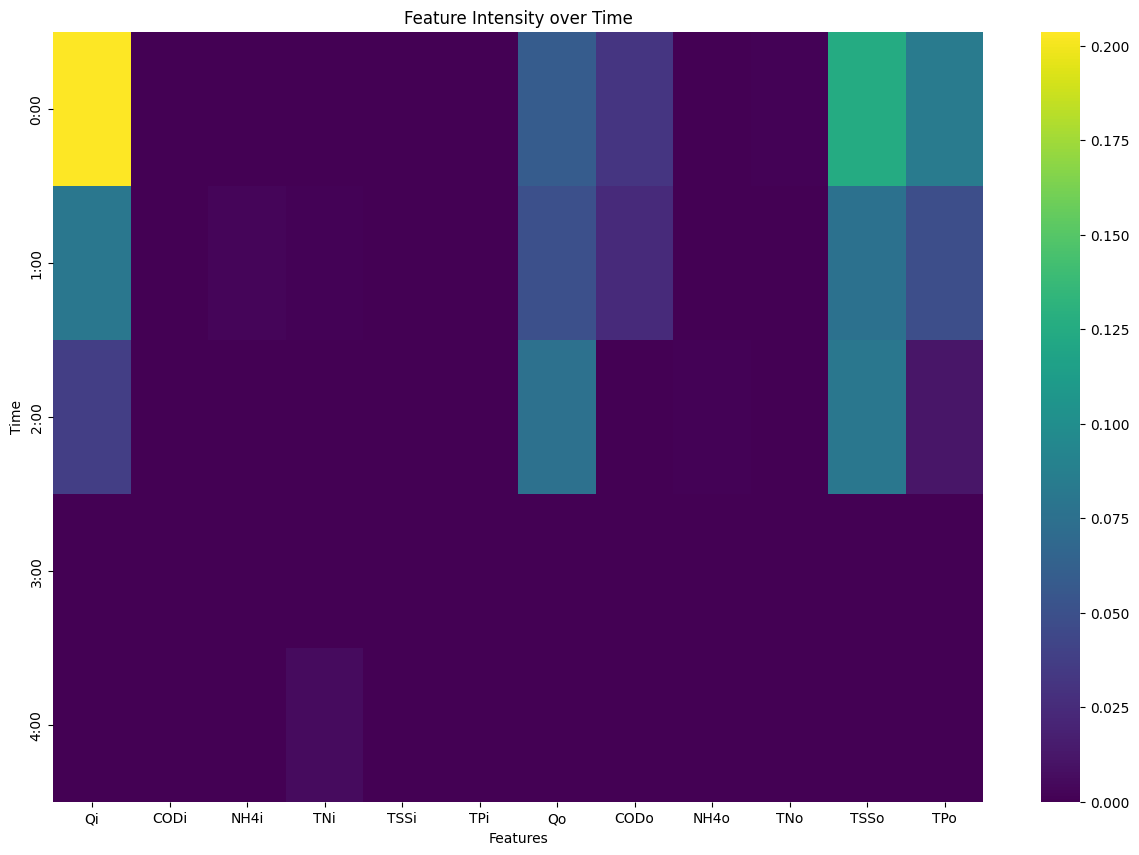

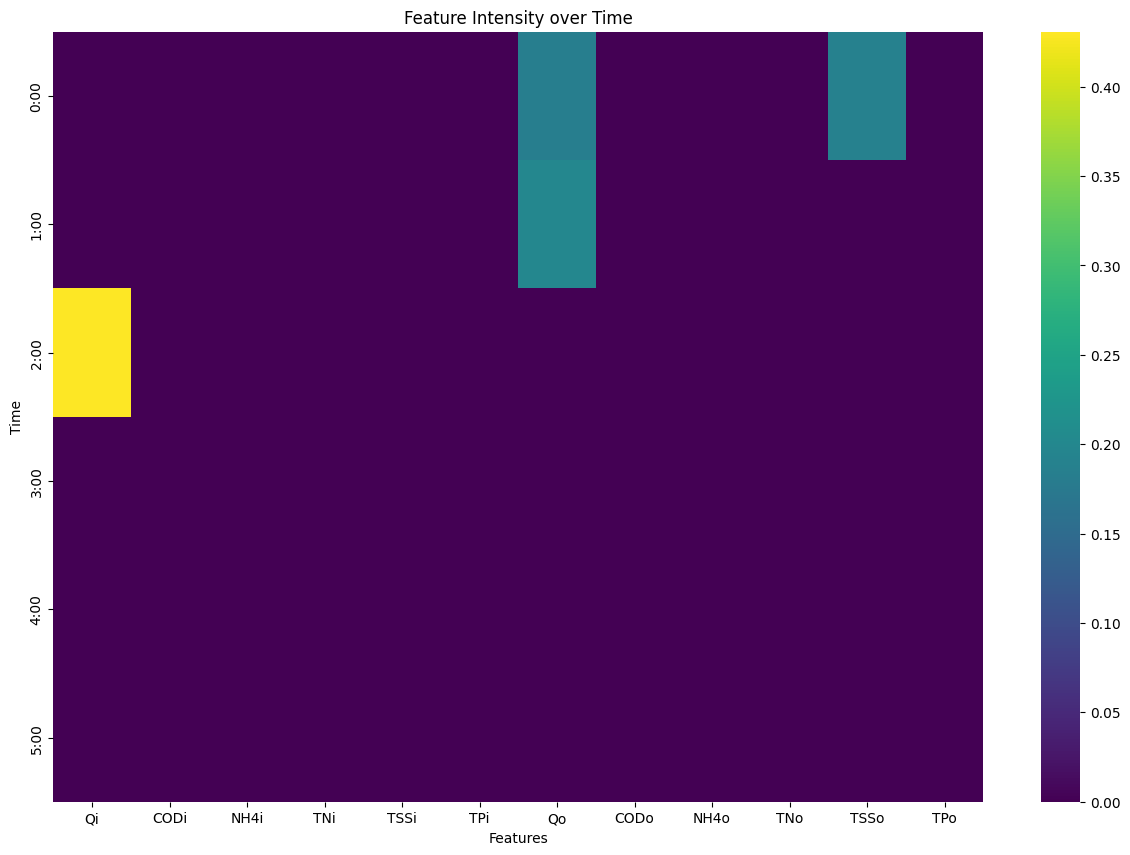

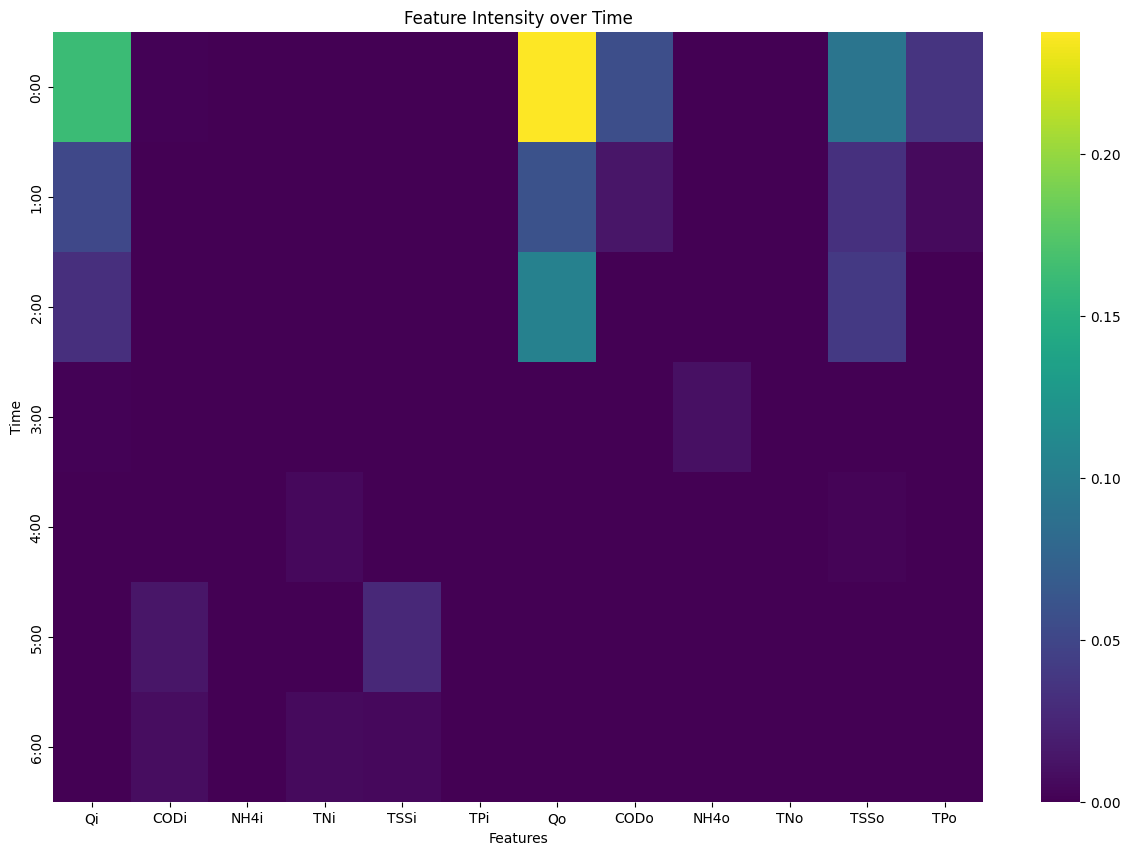

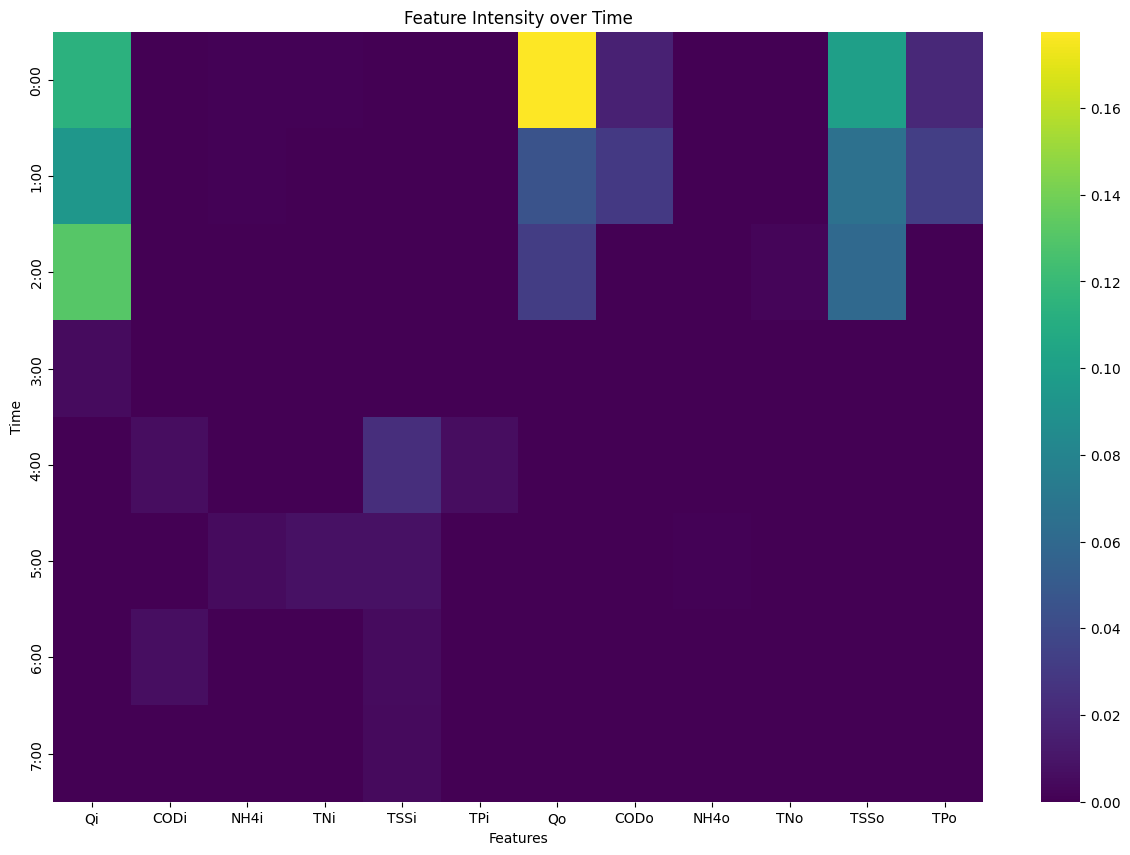

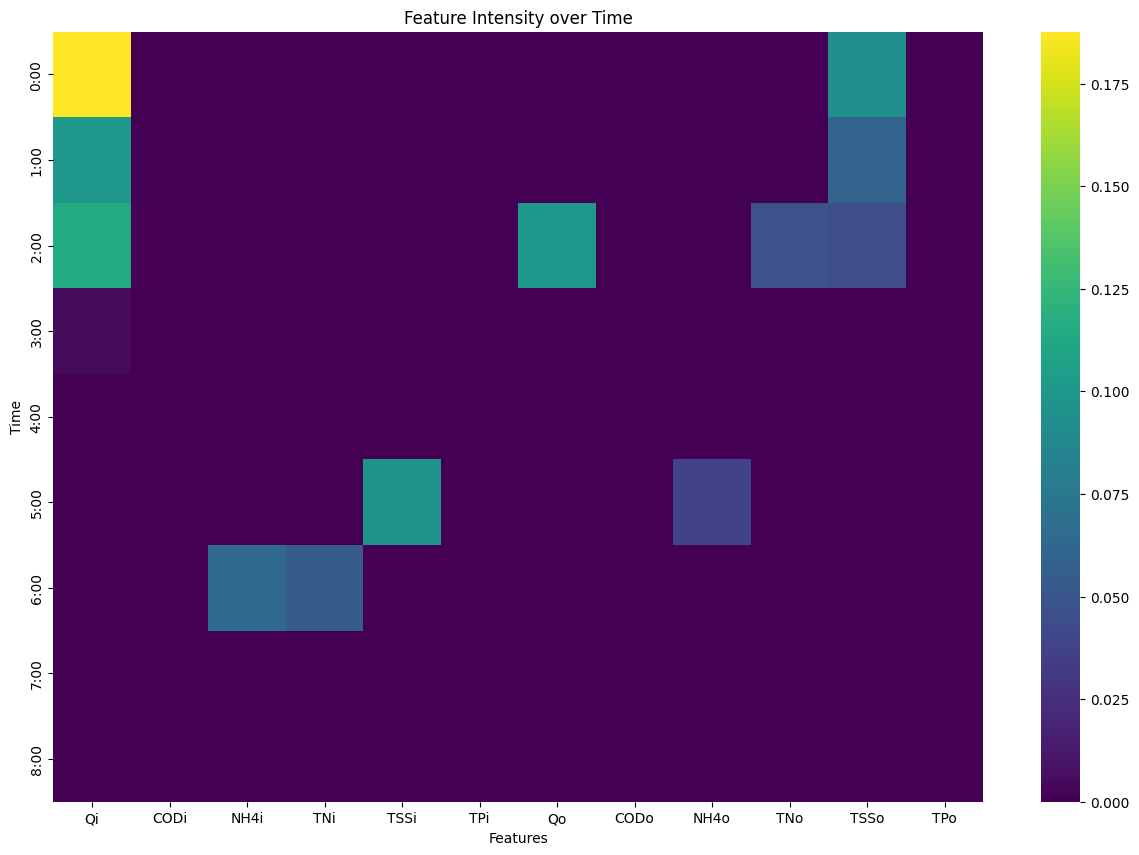

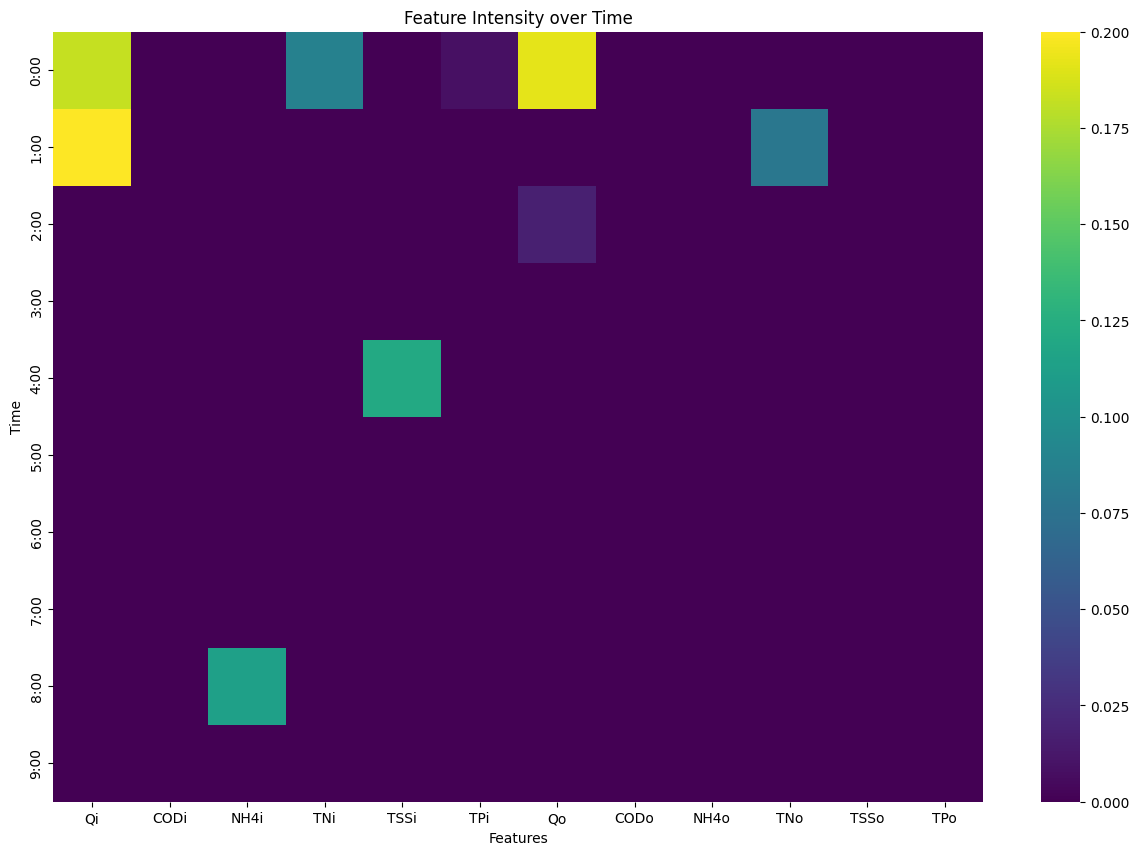

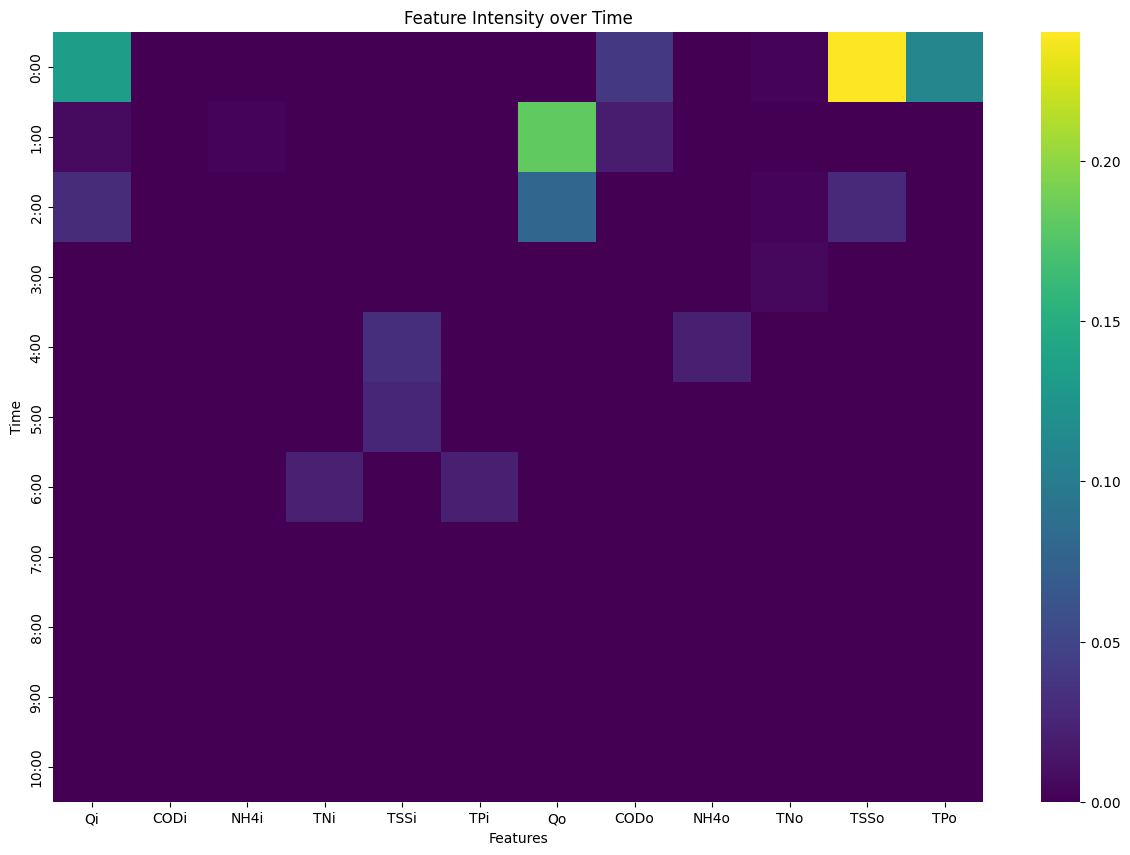

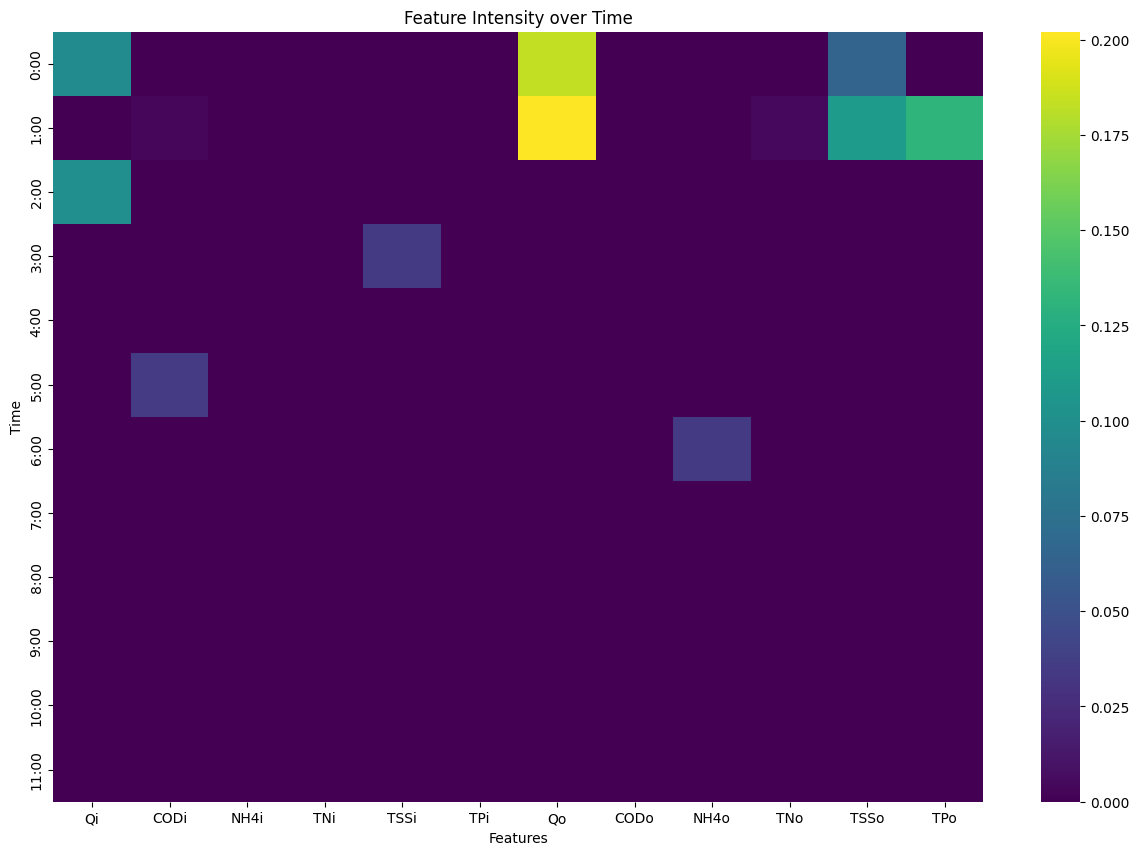

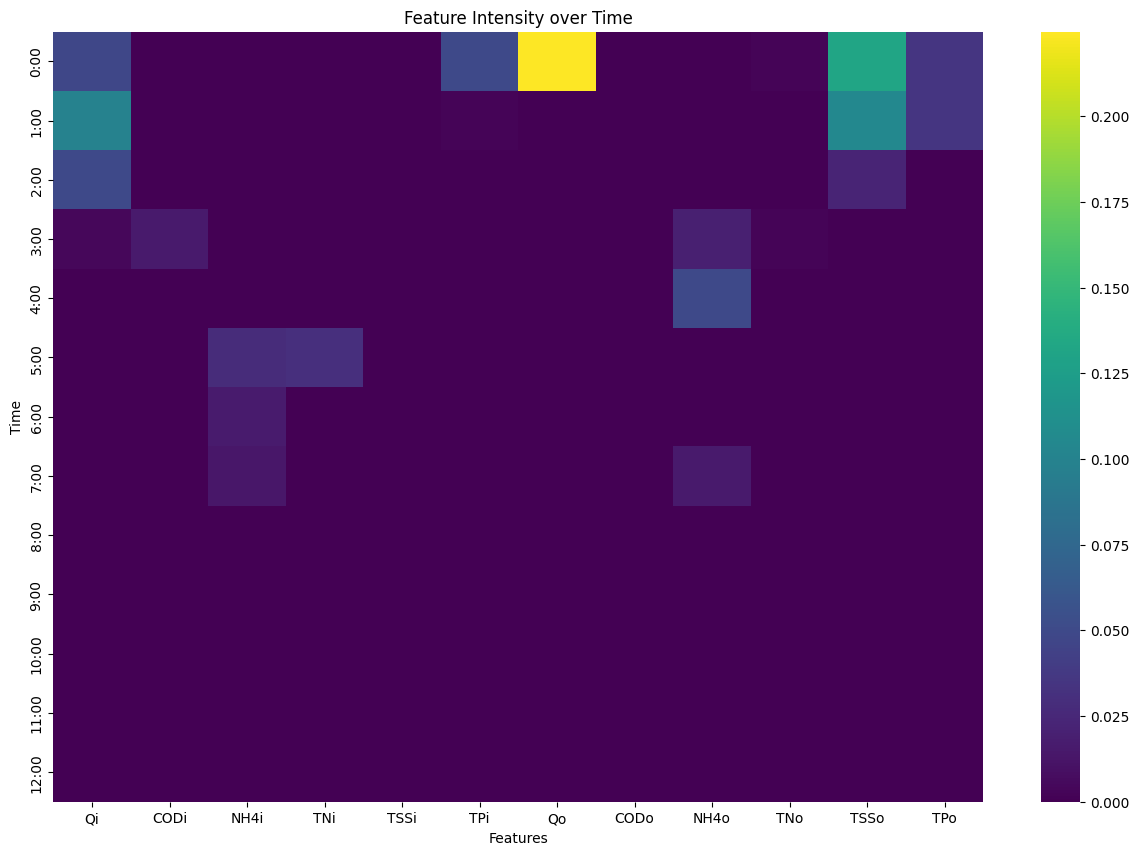

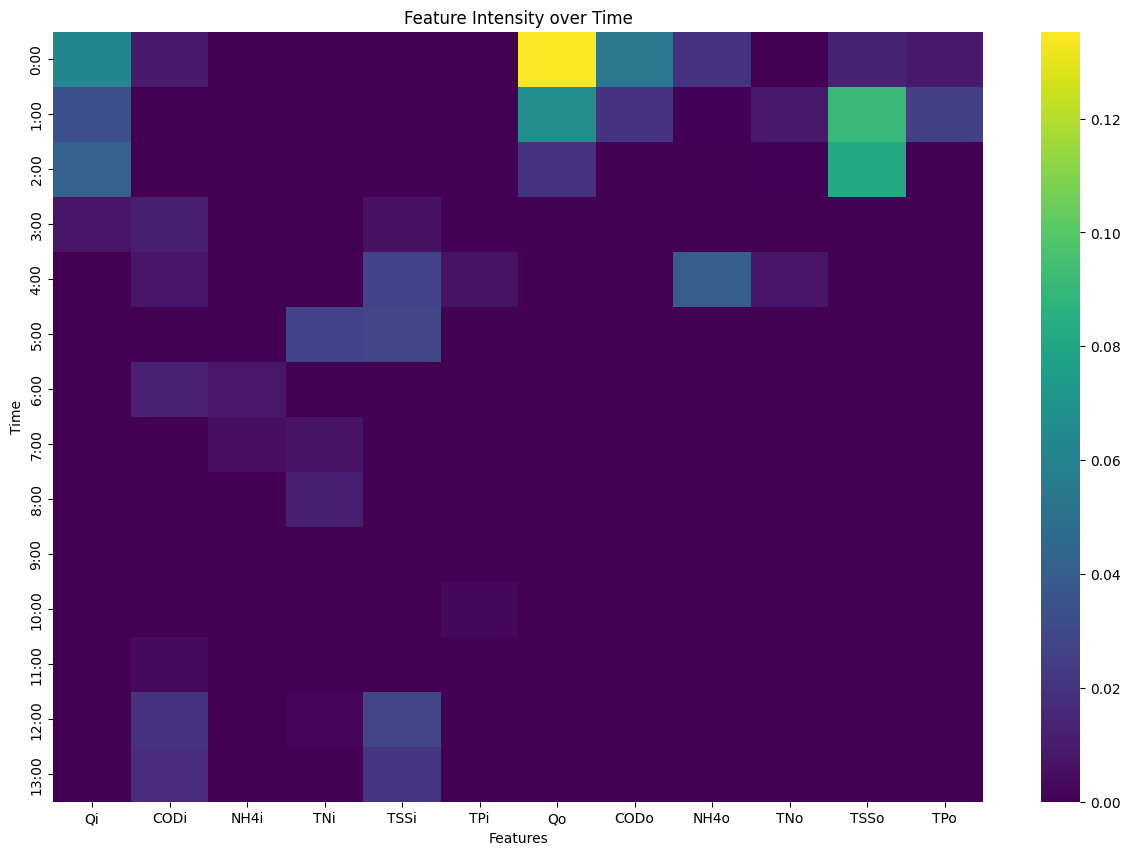

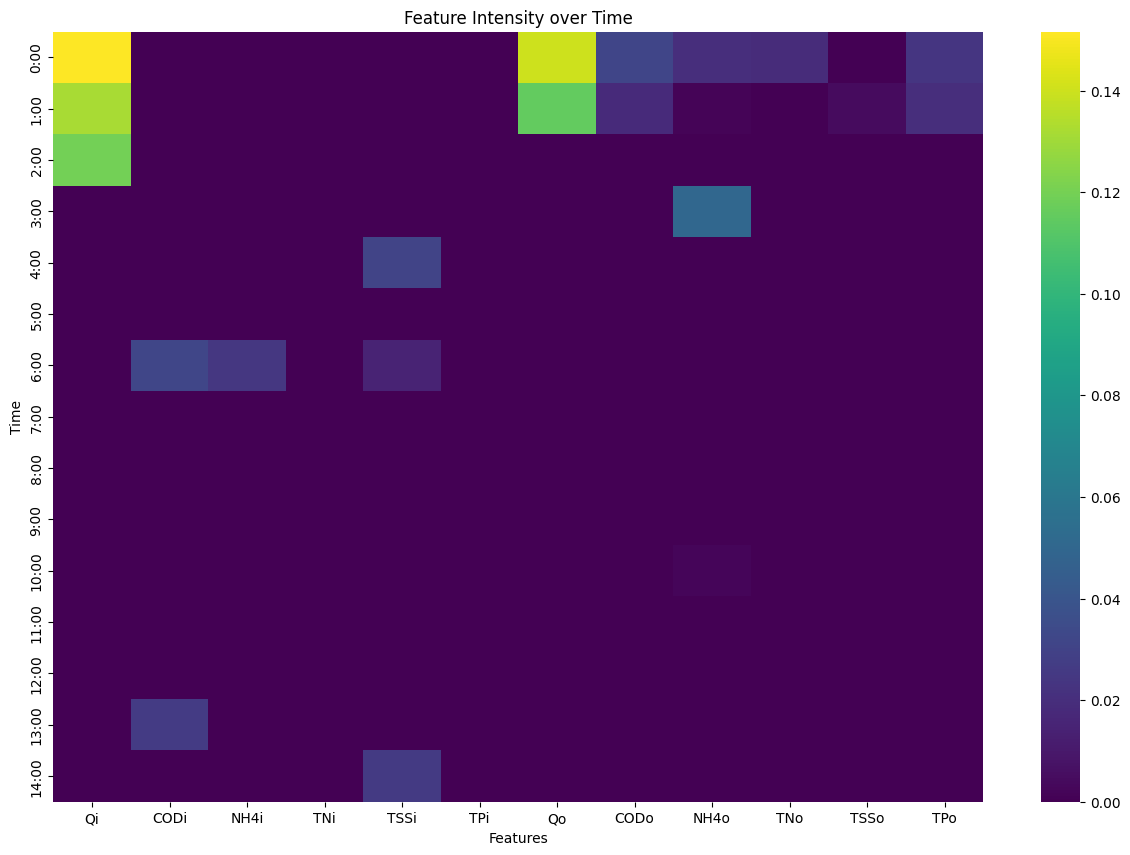

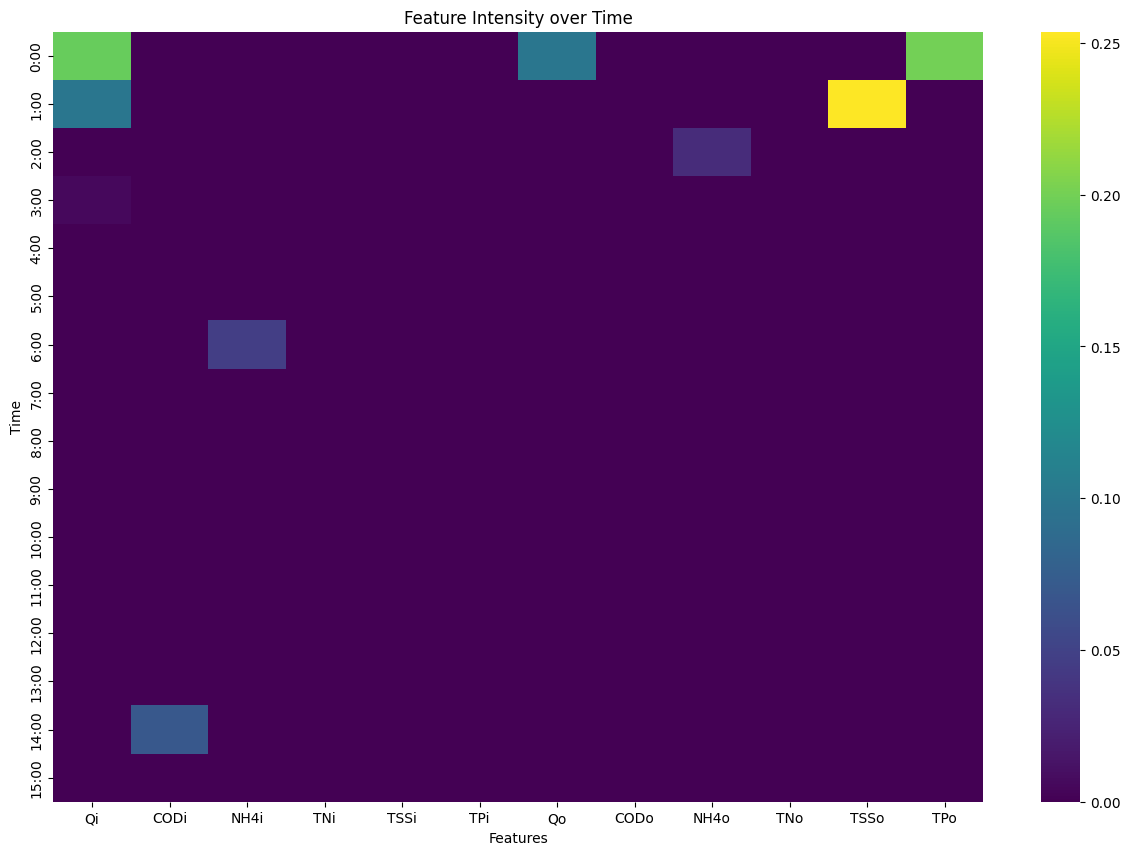

In [33]:
# eqi
n_features = 12

kk = 0
df_ = df[df['kk'] == kk]
X = df_hourly.drop(columns=columns_to_drop)
y_ = df_hourly['EQI']

X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, shuffle=False)

model = df_.iloc[0]['grid']
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

importances = model.feature_importances_

np.random.seed(0)
data = importances.reshape(int(kk)+1, n_features)

# Create time and feature labels for the axes
time_labels = [f"{i}:00" for i in range(data.shape[0])]
feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

# Adding titles and labels
plt.title("Feature Intensity over Time")
plt.xlabel("Features")
plt.ylabel("Time")

# Show the plot
plt.show()

for kk in list_hours_shifted:
    df_ = df[df['kk'] == kk]
    fname_prefix = 'data/df_delay_'
    fname_postfix = '_hours_result_sim2.pkl'

    # create the file name and input data
    file_name = fname_prefix + kk + fname_postfix
    df_delay_16_hours_result=pd.read_pickle(file_name)

    list_names_new = []
    kk_int=int(kk)
    # remove the columns that are not used in the input data file
    for ii in range(0,len(columns_to_drop)):
        for jj in range(0,kk_int+1):
            if jj==0:
                list_names_new.append(columns_to_drop[ii])
            else:
                list_names_new.append(columns_to_drop[ii]+str(jj))
    
    y_ = df_delay_16_hours_result['EQI']
    X = df_delay_16_hours_result.drop(columns=list_names_new)

    X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, shuffle=False)

    model = df_.iloc[0]['grid']
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    importances = model.feature_importances_
    
    np.random.seed(0)
    data = importances.reshape(int(kk)+1, n_features)

    # Create time and feature labels for the axes
    time_labels = [f"{i}:00" for i in range(data.shape[0])]
    feature_labels = [f"{feature}" for feature in X_train.columns[:n_features]]

    # Create the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(data, annot=False, fmt=".2f", xticklabels=feature_labels, yticklabels=time_labels, cmap="viridis")

    # Adding titles and labels
    plt.title("Feature Intensity over Time")
    plt.xlabel("Features")
    plt.ylabel("Time")

    # Show the plot
    plt.show()

In [34]:
df

,kk,test_size,grid,train_acc,test_acc,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse,train_mape,test_mape
0,0,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",76.713689,74.579684,1545.836119,1677.849369,5.558309e+06,8.090347e+06,2357.606542,2844.353510,23.286311,25.420316
1,1,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",77.700358,75.331641,1508.291567,1646.202946,5.189621e+06,7.520106e+06,2278.074032,2742.281118,22.299642,24.668359
2,2,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",76.415170,73.809073,1563.826109,1713.315756,5.457547e+06,7.907793e+06,2336.139366,2812.079843,23.584830,26.190927
3,3,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",77.254444,74.778379,1511.373696,1662.589763,5.212637e+06,7.687911e+06,2283.120046,2772.708293,22.745556,25.221621
4,4,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",73.701541,70.619756,1724.103235,1877.517616,6.223743e+06,8.675494e+06,2494.743041,2945.419154,26.298459,29.380244
5,5,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",72.204464,68.865821,1824.535420,2003.781163,6.513999e+06,9.028339e+06,2552.253800,3004.719425,27.795536,31.134179
6,6,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",76.048251,73.133329,1597.829941,1758.847318,5.741567e+06,8.300720e+06,2396.156813,2881.096997,23.951749,26.866671
7,7,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",73.958056,71.082979,1704.061966,1843.681032,6.190947e+06,8.639463e+06,2488.161303,2939.296376,26.041944,28.917021
8,8,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",71.709674,68.628562,1832.001165,1977.794577,6.866615e+06,9.457327e+06,2620.422650,3075.276806,28.290326,31.371438
9,9,0.3,"(DecisionTreeRegressor(max_depth=2, max_featur...",73.489414,71.521267,1687.674886,1776.024486,6.175007e+06,8.602981e+06,2484.956067,2933.083801,26.510586,28.478733
